In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset 🗂️**

## Transform

In [49]:
transform_train = transforms.Compose([
    transforms.ToTensor()
    ])

transform_test = transforms.Compose([
    transforms.ToTensor()
    ])

## MNIST Dataset

In [50]:
train_set = datasets.MNIST('./', train=True, transform = transform_train, download=True)

test_set = datasets.MNIST('./', train=False, transform = transform_test, download=True)

In [51]:
# جهت تست مدل
# _, mini_train_set = random_split(train_set, (len(train_set)-500, 500))
# _, mini_test_set = random_split(test_set, (len(test_set)-100, 100))

In [52]:
train_set.data.shape

torch.Size([60000, 28, 28])

In [53]:
train_set.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [54]:
torch.FloatTensor(train_set.data/255.).mean(dim=[0, 1,2])
torch.FloatTensor(train_set.data/255.).std(dim=[0, 1,2])

tensor(0.3081)

## DataLoader

In [55]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

## Visualize

In [56]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

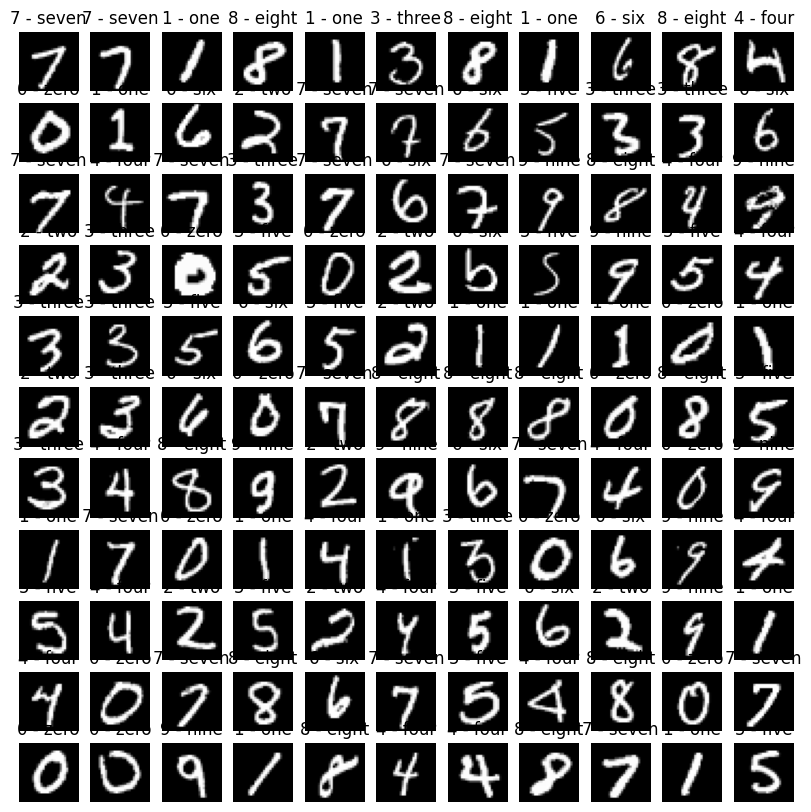

In [57]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# **Device**

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Utils 🧰**

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## set color for plat

In [15]:
import random
label_colors = {}
for label in range(10):
    if label not in label_colors:
        label_colors[label] = (random.random(), random.random(), random.random())  # انتخاب یک رنگ تصادفی

# 1- **RNN AutoEncoer** Method 1

## Train Functions 🧮

In [37]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device).squeeze()
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())

      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [38]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device).squeeze()
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss_valid.update(loss.item())
  return loss_valid.avg, inputs, outputs

In [39]:
x,y = next(iter(train_loader))

In [40]:
x.squeeze().shape

torch.Size([128, 28, 28])

In [41]:
test = nn.RNN(28, 32,batch_first=True)

In [42]:
out, hidden= test(x.squeeze())

In [43]:
out[:, -1].shape

torch.Size([128, 32])

## model

In [44]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # input size, 1, 28, 28
        self.rnn1 = nn.RNN(28, 128,batch_first=True)
        self.rnn2= nn.RNN(128, 64,batch_first=True)
        self.rnn3= nn.RNN(64, 32,batch_first=True)

        self.rnn4 = nn.RNN(32, 64,batch_first=True)
        self.rnn5= nn.RNN(64, 128,batch_first=True)
        self.rnn6= nn.RNN(128, 28,batch_first=True)

    def encoder(self, x):
        y,_ = self.rnn1(x)
        y,_ = self.rnn2(y)
        y,hidden_state = self.rnn3(y)
        return y ,hidden_state
    def decoder(self, x):
        y,_ = self.rnn4(x)
        y,_ = self.rnn5(y)
        y,hidden_state = self.rnn6(y)
        return y,hidden_state

    def forward(self, x):
        encoded , _= self.encoder(x)
        decoded ,hidden_state= self.decoder(encoded)
        return decoded

In [45]:
model = Autoencoder()
model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [46]:
loss_train_hist = []
loss_valid_hist = []
outputs = []

best_loss_valid = torch.inf
epoch_counter = 0

In [47]:
num_epochs = 100

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid, inputs, out_puts = validation(model,
                        test_loader,
                        loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  outputs.append((epoch, inputs, out_puts))

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 469/469 [00:12<00:00, 36.85batch/s, loss=0.0135]


Valid: Loss = 0.004538



Epoch 1: 100%|██████████| 469/469 [00:12<00:00, 37.14batch/s, loss=0.00344]


Valid: Loss = 0.002772



Epoch 2: 100%|██████████| 469/469 [00:12<00:00, 37.18batch/s, loss=0.0024]


Valid: Loss = 0.002211



Epoch 3: 100%|██████████| 469/469 [00:14<00:00, 33.42batch/s, loss=0.00175]


Valid: Loss = 0.001822



Epoch 4: 100%|██████████| 469/469 [00:13<00:00, 35.65batch/s, loss=0.0015]


Valid: Loss = 0.001394



Epoch 5: 100%|██████████| 469/469 [00:12<00:00, 36.40batch/s, loss=0.0013]


Valid: Loss = 0.001137



Epoch 6: 100%|██████████| 469/469 [00:12<00:00, 37.22batch/s, loss=0.00112]


Valid: Loss = 0.0009884



Epoch 7: 100%|██████████| 469/469 [00:13<00:00, 35.13batch/s, loss=0.000992]


Valid: Loss = 0.0008777



Epoch 8: 100%|██████████| 469/469 [00:12<00:00, 37.67batch/s, loss=0.000886]


Valid: Loss = 0.0008632



Epoch 9: 100%|██████████| 469/469 [00:12<00:00, 37.68batch/s, loss=0.000842]


Valid: Loss = 0.0007415



Epoch 10: 100%|██████████| 469/469 [00:23<00:00, 19.92batch/s, loss=0.000789]


Valid: Loss = 0.0007764



Epoch 11: 100%|██████████| 469/469 [00:11<00:00, 39.74batch/s, loss=0.000757]


Valid: Loss = 0.0006719



Epoch 12: 100%|██████████| 469/469 [00:11<00:00, 39.64batch/s, loss=0.000724]


Valid: Loss = 0.0006534



Epoch 13: 100%|██████████| 469/469 [00:11<00:00, 39.64batch/s, loss=0.000703]


Valid: Loss = 0.0006454



Epoch 14: 100%|██████████| 469/469 [00:11<00:00, 39.82batch/s, loss=0.000679]


Valid: Loss = 0.0007418



Epoch 15: 100%|██████████| 469/469 [00:11<00:00, 39.37batch/s, loss=0.000659]


Valid: Loss = 0.0005953



Epoch 16: 100%|██████████| 469/469 [00:12<00:00, 38.77batch/s, loss=0.000629]


Valid: Loss = 0.0005839



Epoch 17: 100%|██████████| 469/469 [00:12<00:00, 38.37batch/s, loss=0.000616]


Valid: Loss = 0.0005912



Epoch 18: 100%|██████████| 469/469 [00:14<00:00, 31.67batch/s, loss=0.000594]


Valid: Loss = 0.0005538



Epoch 19: 100%|██████████| 469/469 [00:11<00:00, 39.56batch/s, loss=0.000579]


Valid: Loss = 0.0006536



Epoch 20: 100%|██████████| 469/469 [00:11<00:00, 39.58batch/s, loss=0.000563]


Valid: Loss = 0.0006691



Epoch 21: 100%|██████████| 469/469 [00:20<00:00, 22.49batch/s, loss=0.000563]


Valid: Loss = 0.000529



Epoch 22: 100%|██████████| 469/469 [00:16<00:00, 29.19batch/s, loss=0.000545]


Valid: Loss = 0.0005403



Epoch 23: 100%|██████████| 469/469 [00:12<00:00, 38.58batch/s, loss=0.000548]


Valid: Loss = 0.0004941



Epoch 24: 100%|██████████| 469/469 [00:12<00:00, 38.12batch/s, loss=0.000607]


Valid: Loss = 0.0004883



Epoch 25: 100%|██████████| 469/469 [00:12<00:00, 37.79batch/s, loss=0.000509]


Valid: Loss = 0.0004866



Epoch 26: 100%|██████████| 469/469 [00:12<00:00, 37.58batch/s, loss=0.000526]


Valid: Loss = 0.0004815



Epoch 27: 100%|██████████| 469/469 [00:12<00:00, 37.99batch/s, loss=0.000512]


Valid: Loss = 0.0006001



Epoch 28: 100%|██████████| 469/469 [00:12<00:00, 37.38batch/s, loss=0.000506]


Valid: Loss = 0.0004659



Epoch 29: 100%|██████████| 469/469 [00:13<00:00, 35.87batch/s, loss=0.000504]


Valid: Loss = 0.0004529



Epoch 30: 100%|██████████| 469/469 [00:13<00:00, 35.08batch/s, loss=0.000503]


Valid: Loss = 0.0004945



Epoch 31: 100%|██████████| 469/469 [00:13<00:00, 34.04batch/s, loss=0.000496]


Valid: Loss = 0.0004544



Epoch 32: 100%|██████████| 469/469 [00:12<00:00, 37.28batch/s, loss=0.000492]


Valid: Loss = 0.0004681



Epoch 33: 100%|██████████| 469/469 [00:12<00:00, 37.41batch/s, loss=0.000488]


Valid: Loss = 0.00045



Epoch 34: 100%|██████████| 469/469 [00:12<00:00, 37.75batch/s, loss=0.000482]


Valid: Loss = 0.0004449



Epoch 35: 100%|██████████| 469/469 [00:12<00:00, 37.50batch/s, loss=0.000484]


Valid: Loss = 0.0004462



Epoch 36: 100%|██████████| 469/469 [00:12<00:00, 37.31batch/s, loss=0.000481]


Valid: Loss = 0.0005636



Epoch 37: 100%|██████████| 469/469 [00:12<00:00, 36.87batch/s, loss=0.000471]


Valid: Loss = 0.0004337



Epoch 38: 100%|██████████| 469/469 [00:13<00:00, 35.47batch/s, loss=0.000477]


Valid: Loss = 0.0004342



Epoch 39: 100%|██████████| 469/469 [00:12<00:00, 37.24batch/s, loss=0.000466]


Valid: Loss = 0.0004254



Epoch 40: 100%|██████████| 469/469 [00:12<00:00, 37.48batch/s, loss=0.000473]


Valid: Loss = 0.000543



Epoch 41: 100%|██████████| 469/469 [00:12<00:00, 37.20batch/s, loss=0.000459]


Valid: Loss = 0.0004236



Epoch 42: 100%|██████████| 469/469 [00:12<00:00, 36.69batch/s, loss=0.000465]


Valid: Loss = 0.0004208



Epoch 43: 100%|██████████| 469/469 [00:12<00:00, 36.85batch/s, loss=0.000449]


Valid: Loss = 0.0004176



Epoch 44: 100%|██████████| 469/469 [00:12<00:00, 36.85batch/s, loss=0.000453]


Valid: Loss = 0.0004849



Epoch 45: 100%|██████████| 469/469 [00:13<00:00, 35.21batch/s, loss=0.000451]


Valid: Loss = 0.0005067



Epoch 46: 100%|██████████| 469/469 [00:12<00:00, 37.05batch/s, loss=0.000453]


Valid: Loss = 0.0009411



Epoch 47: 100%|██████████| 469/469 [00:12<00:00, 36.84batch/s, loss=0.000436]


Valid: Loss = 0.0004512



Epoch 48: 100%|██████████| 469/469 [00:13<00:00, 35.85batch/s, loss=0.000427]


Valid: Loss = 0.0005093



Epoch 49: 100%|██████████| 469/469 [00:13<00:00, 34.44batch/s, loss=0.00043]


Valid: Loss = 0.000476



Epoch 50: 100%|██████████| 469/469 [00:14<00:00, 33.14batch/s, loss=0.000424]


Valid: Loss = 0.0004095



Epoch 51: 100%|██████████| 469/469 [00:13<00:00, 34.04batch/s, loss=0.000426]


Valid: Loss = 0.0003908



Epoch 52: 100%|██████████| 469/469 [00:13<00:00, 35.07batch/s, loss=0.000411]


Valid: Loss = 0.0004061



Epoch 53: 100%|██████████| 469/469 [00:13<00:00, 34.59batch/s, loss=0.000435]


Valid: Loss = 0.000382



Epoch 54: 100%|██████████| 469/469 [00:13<00:00, 36.06batch/s, loss=0.000401]


Valid: Loss = 0.0003733



Epoch 55: 100%|██████████| 469/469 [00:13<00:00, 35.45batch/s, loss=0.000404]


Valid: Loss = 0.0003837



Epoch 56: 100%|██████████| 469/469 [00:13<00:00, 35.70batch/s, loss=0.0004]


Valid: Loss = 0.0003646



Epoch 57: 100%|██████████| 469/469 [00:13<00:00, 34.27batch/s, loss=0.000398]


Valid: Loss = 0.0005378



Epoch 58: 100%|██████████| 469/469 [00:13<00:00, 34.40batch/s, loss=0.000397]


Valid: Loss = 0.0003682



Epoch 59: 100%|██████████| 469/469 [00:14<00:00, 33.04batch/s, loss=0.000389]


Valid: Loss = 0.000361



Epoch 60: 100%|██████████| 469/469 [00:14<00:00, 33.33batch/s, loss=0.000391]


Valid: Loss = 0.0003618



Epoch 61: 100%|██████████| 469/469 [00:13<00:00, 33.82batch/s, loss=0.000392]


Valid: Loss = 0.000359



Epoch 62: 100%|██████████| 469/469 [00:13<00:00, 33.67batch/s, loss=0.000387]


Valid: Loss = 0.0003607



Epoch 63: 100%|██████████| 469/469 [00:13<00:00, 33.96batch/s, loss=0.000384]


Valid: Loss = 0.0003493



Epoch 64: 100%|██████████| 469/469 [00:13<00:00, 34.25batch/s, loss=0.000384]


Valid: Loss = 0.0004524



Epoch 65: 100%|██████████| 469/469 [00:13<00:00, 34.06batch/s, loss=0.000377]


Valid: Loss = 0.0004026



Epoch 66: 100%|██████████| 469/469 [00:13<00:00, 34.29batch/s, loss=0.000383]


Valid: Loss = 0.0003428



Epoch 67: 100%|██████████| 469/469 [00:13<00:00, 34.02batch/s, loss=0.000377]


Valid: Loss = 0.0003629



Epoch 68: 100%|██████████| 469/469 [00:13<00:00, 34.89batch/s, loss=0.000378]


Valid: Loss = 0.0003376



Epoch 69: 100%|██████████| 469/469 [00:13<00:00, 35.14batch/s, loss=0.000377]


Valid: Loss = 0.0003344



Epoch 70: 100%|██████████| 469/469 [00:13<00:00, 35.32batch/s, loss=0.000355]


Valid: Loss = 0.0003444



Epoch 71: 100%|██████████| 469/469 [00:13<00:00, 35.78batch/s, loss=0.000363]


Valid: Loss = 0.0003339



Epoch 72: 100%|██████████| 469/469 [00:12<00:00, 36.40batch/s, loss=0.000359]


Valid: Loss = 0.0003335



Epoch 73: 100%|██████████| 469/469 [00:12<00:00, 36.74batch/s, loss=0.00036]


Valid: Loss = 0.0003464



Epoch 74: 100%|██████████| 469/469 [00:12<00:00, 37.20batch/s, loss=0.000361]


Valid: Loss = 0.0003737



Epoch 75: 100%|██████████| 469/469 [00:12<00:00, 37.52batch/s, loss=0.000353]


Valid: Loss = 0.0004079



Epoch 76: 100%|██████████| 469/469 [00:12<00:00, 36.96batch/s, loss=0.000355]


Valid: Loss = 0.0003412



Epoch 77: 100%|██████████| 469/469 [00:12<00:00, 37.70batch/s, loss=0.000359]


Valid: Loss = 0.0003352



Epoch 78: 100%|██████████| 469/469 [00:12<00:00, 37.10batch/s, loss=0.00037]


Valid: Loss = 0.0003212



Epoch 79: 100%|██████████| 469/469 [00:12<00:00, 36.68batch/s, loss=0.000346]


Valid: Loss = 0.00034



Epoch 80: 100%|██████████| 469/469 [00:12<00:00, 37.65batch/s, loss=0.00035]


Valid: Loss = 0.0003255



Epoch 81: 100%|██████████| 469/469 [00:12<00:00, 37.71batch/s, loss=0.000351]


Valid: Loss = 0.0003462



Epoch 82: 100%|██████████| 469/469 [00:12<00:00, 37.97batch/s, loss=0.000349]


Valid: Loss = 0.0003215



Epoch 83: 100%|██████████| 469/469 [00:12<00:00, 37.35batch/s, loss=0.000353]


Valid: Loss = 0.0003292



Epoch 84: 100%|██████████| 469/469 [00:12<00:00, 37.23batch/s, loss=0.000356]


Valid: Loss = 0.0005731



Epoch 85: 100%|██████████| 469/469 [00:12<00:00, 38.00batch/s, loss=0.00035]


Valid: Loss = 0.0003352



Epoch 86: 100%|██████████| 469/469 [00:12<00:00, 37.12batch/s, loss=0.000349]


Valid: Loss = 0.0003198



Epoch 87: 100%|██████████| 469/469 [00:12<00:00, 36.65batch/s, loss=0.00035]


Valid: Loss = 0.000332



Epoch 88: 100%|██████████| 469/469 [00:12<00:00, 37.38batch/s, loss=0.00035]


Valid: Loss = 0.0003262



Epoch 89: 100%|██████████| 469/469 [00:12<00:00, 37.93batch/s, loss=0.000347]


Valid: Loss = 0.0003404



Epoch 90: 100%|██████████| 469/469 [00:12<00:00, 37.52batch/s, loss=0.000345]


Valid: Loss = 0.0003764



Epoch 91: 100%|██████████| 469/469 [00:12<00:00, 37.51batch/s, loss=0.000358]


Valid: Loss = 0.0003161



Epoch 92: 100%|██████████| 469/469 [00:12<00:00, 37.36batch/s, loss=0.000344]


Valid: Loss = 0.0003221



Epoch 93: 100%|██████████| 469/469 [00:12<00:00, 37.94batch/s, loss=0.000345]


Valid: Loss = 0.0003253



Epoch 94: 100%|██████████| 469/469 [00:12<00:00, 37.54batch/s, loss=0.000349]


Valid: Loss = 0.0003465



Epoch 95: 100%|██████████| 469/469 [00:12<00:00, 37.10batch/s, loss=0.000348]


Valid: Loss = 0.0003165



Epoch 96: 100%|██████████| 469/469 [00:12<00:00, 36.93batch/s, loss=0.000345]


Valid: Loss = 0.0003194



Epoch 97: 100%|██████████| 469/469 [00:12<00:00, 37.66batch/s, loss=0.000345]


Valid: Loss = 0.0003173



Epoch 98: 100%|██████████| 469/469 [00:12<00:00, 36.34batch/s, loss=0.00036]


Valid: Loss = 0.0003236



Epoch 99: 100%|██████████| 469/469 [00:12<00:00, 37.40batch/s, loss=0.000339]


Valid: Loss = 0.0003265



## save and load model

In [48]:
torch.save(model, '/content/drive/MyDrive/Advance_deep/week2/RNN_AutoEncoer_Method1.pth')
model = torch.load('/content/drive/MyDrive/Advance_deep/week2/RNN_AutoEncoer_Method1.pth')

## vitualize

In [49]:
encoder = model.encoder
image = train_set[i][0].to(device)
_ , encoded_image = encoder(image)

In [50]:
encoded_image.squeeze().shape

torch.Size([32])

In [51]:
embded = []
encoder = model.encoder
for i in range(500):
  image = train_set[i][0].to(device)
  _ , encoded_image = encoder(image)
  embded.append(encoded_image.squeeze().detach().cpu().numpy())
embded_array = np.array(embded)

In [52]:
embded_array.shape

(500, 32)

In [53]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embded_array)

<ipython-input-54-63c4c88f143e>:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])


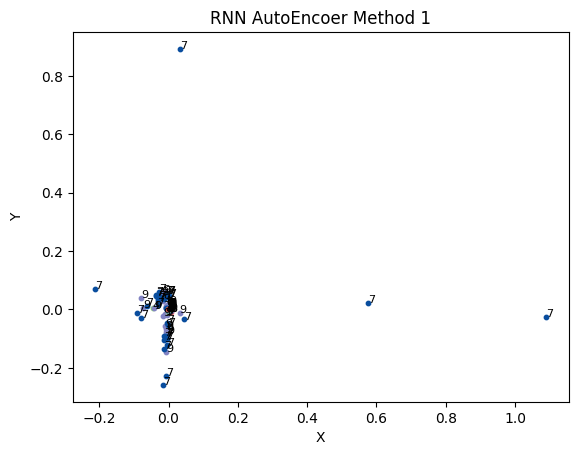

<Figure size 1400x1000 with 0 Axes>

In [54]:
import matplotlib.pyplot as plt

for i in range(500):
    plt.text(pca_result[i][0], pca_result[i][1], train_set[i][1], fontsize=8)
    plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])

# نام‌گذاری محورها
plt.xlabel('X')
plt.ylabel('Y')

# عنوان نمودار
plt.title('RNN AutoEncoer Method 1')
plt.figure(figsize=(14, 10))
# نمایش نمودار
plt.show()

# 2- **RNN AutoEncoer** Method 2

## Train Functions 🧮

In [19]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device).squeeze()
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())

      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [20]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device).squeeze()
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss_valid.update(loss.item())
  return loss_valid.avg, inputs, outputs

## model

In [21]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # input size, 1, 28, 28
        self.encoder = nn.RNN(28, 128, 3, batch_first=True)
        self.decoder = nn.RNN(128, 28, 3, batch_first=True)

    def forward(self, x):
        encoded , _= self.encoder(x)
        decoded ,hidden_state= self.decoder(encoded)
        return decoded

In [22]:
model = Autoencoder()
model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [23]:
loss_train_hist = []
loss_valid_hist = []
outputs = []

best_loss_valid = torch.inf
epoch_counter = 0

In [24]:
num_epochs = 100

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid, inputs, out_puts = validation(model,
                        test_loader,
                        loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  outputs.append((epoch, inputs, out_puts))

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 469/469 [00:12<00:00, 37.09batch/s, loss=0.0201]


Valid: Loss = 0.00657



Epoch 1: 100%|██████████| 469/469 [00:10<00:00, 42.78batch/s, loss=0.00492]


Valid: Loss = 0.003723



Epoch 2: 100%|██████████| 469/469 [00:11<00:00, 41.71batch/s, loss=0.00321]


Valid: Loss = 0.002741



Epoch 3: 100%|██████████| 469/469 [00:11<00:00, 40.93batch/s, loss=0.00251]


Valid: Loss = 0.002162



Epoch 4: 100%|██████████| 469/469 [00:11<00:00, 40.43batch/s, loss=0.00203]


Valid: Loss = 0.002676



Epoch 5: 100%|██████████| 469/469 [00:11<00:00, 40.32batch/s, loss=0.00174]


Valid: Loss = 0.001586



Epoch 6: 100%|██████████| 469/469 [00:11<00:00, 40.86batch/s, loss=0.00153]


Valid: Loss = 0.001368



Epoch 7: 100%|██████████| 469/469 [00:11<00:00, 40.51batch/s, loss=0.00133]


Valid: Loss = 0.001198



Epoch 8: 100%|██████████| 469/469 [00:12<00:00, 39.04batch/s, loss=0.0012]


Valid: Loss = 0.001086



Epoch 9: 100%|██████████| 469/469 [00:12<00:00, 37.74batch/s, loss=0.0011]


Valid: Loss = 0.0009824



Epoch 10: 100%|██████████| 469/469 [00:10<00:00, 43.45batch/s, loss=0.001]


Valid: Loss = 0.0009206



Epoch 11: 100%|██████████| 469/469 [00:10<00:00, 43.39batch/s, loss=0.000938]


Valid: Loss = 0.0009586



Epoch 12: 100%|██████████| 469/469 [00:11<00:00, 41.33batch/s, loss=0.000898]


Valid: Loss = 0.0008362



Epoch 13: 100%|██████████| 469/469 [00:11<00:00, 40.20batch/s, loss=0.000847]


Valid: Loss = 0.0007968



Epoch 14: 100%|██████████| 469/469 [00:11<00:00, 39.93batch/s, loss=0.00081]


Valid: Loss = 0.0009794



Epoch 15: 100%|██████████| 469/469 [00:11<00:00, 39.64batch/s, loss=0.000774]


Valid: Loss = 0.0007511



Epoch 16: 100%|██████████| 469/469 [00:11<00:00, 40.12batch/s, loss=0.000736]


Valid: Loss = 0.000778



Epoch 17: 100%|██████████| 469/469 [00:11<00:00, 39.66batch/s, loss=0.000714]


Valid: Loss = 0.0007115



Epoch 18: 100%|██████████| 469/469 [00:11<00:00, 40.55batch/s, loss=0.000694]


Valid: Loss = 0.0006787



Epoch 19: 100%|██████████| 469/469 [00:11<00:00, 42.02batch/s, loss=0.000679]


Valid: Loss = 0.0006479



Epoch 20: 100%|██████████| 469/469 [00:10<00:00, 43.38batch/s, loss=0.000661]


Valid: Loss = 0.0006863



Epoch 21: 100%|██████████| 469/469 [00:11<00:00, 42.05batch/s, loss=0.000654]


Valid: Loss = 0.0006121



Epoch 22: 100%|██████████| 469/469 [00:11<00:00, 40.45batch/s, loss=0.000644]


Valid: Loss = 0.0005984



Epoch 23: 100%|██████████| 469/469 [00:11<00:00, 39.96batch/s, loss=0.000632]


Valid: Loss = 0.0006037



Epoch 24: 100%|██████████| 469/469 [00:11<00:00, 39.89batch/s, loss=0.000627]


Valid: Loss = 0.0005776



Epoch 25: 100%|██████████| 469/469 [00:11<00:00, 40.36batch/s, loss=0.000621]


Valid: Loss = 0.0006021



Epoch 26: 100%|██████████| 469/469 [00:11<00:00, 39.98batch/s, loss=0.000609]


Valid: Loss = 0.0005674



Epoch 27: 100%|██████████| 469/469 [00:11<00:00, 40.57batch/s, loss=0.000609]


Valid: Loss = 0.0005812



Epoch 28: 100%|██████████| 469/469 [00:11<00:00, 41.99batch/s, loss=0.000603]


Valid: Loss = 0.0005604



Epoch 29: 100%|██████████| 469/469 [00:10<00:00, 43.66batch/s, loss=0.000598]


Valid: Loss = 0.0005567



Epoch 30: 100%|██████████| 469/469 [00:11<00:00, 42.22batch/s, loss=0.000596]


Valid: Loss = 0.00055



Epoch 31: 100%|██████████| 469/469 [00:11<00:00, 41.22batch/s, loss=0.000589]


Valid: Loss = 0.0005583



Epoch 32: 100%|██████████| 469/469 [00:11<00:00, 40.92batch/s, loss=0.000582]


Valid: Loss = 0.0005524



Epoch 33: 100%|██████████| 469/469 [00:11<00:00, 40.16batch/s, loss=0.00058]


Valid: Loss = 0.0005778



Epoch 34: 100%|██████████| 469/469 [00:11<00:00, 39.95batch/s, loss=0.000575]


Valid: Loss = 0.0005372



Epoch 35: 100%|██████████| 469/469 [00:11<00:00, 40.60batch/s, loss=0.000573]


Valid: Loss = 0.0005691



Epoch 36: 100%|██████████| 469/469 [00:11<00:00, 41.91batch/s, loss=0.000592]


Valid: Loss = 0.0005339



Epoch 37: 100%|██████████| 469/469 [00:10<00:00, 44.10batch/s, loss=0.000559]


Valid: Loss = 0.0005728



Epoch 38: 100%|██████████| 469/469 [00:11<00:00, 41.87batch/s, loss=0.000562]


Valid: Loss = 0.0005719



Epoch 39: 100%|██████████| 469/469 [00:11<00:00, 40.17batch/s, loss=0.00056]


Valid: Loss = 0.000674



Epoch 40: 100%|██████████| 469/469 [00:11<00:00, 39.25batch/s, loss=0.000555]


Valid: Loss = 0.0005201



Epoch 41: 100%|██████████| 469/469 [00:11<00:00, 40.08batch/s, loss=0.000558]


Valid: Loss = 0.0005549



Epoch 42: 100%|██████████| 469/469 [00:11<00:00, 39.63batch/s, loss=0.000551]


Valid: Loss = 0.0005318



Epoch 43: 100%|██████████| 469/469 [00:11<00:00, 39.44batch/s, loss=0.000548]


Valid: Loss = 0.0005195



Epoch 44: 100%|██████████| 469/469 [00:12<00:00, 38.95batch/s, loss=0.000562]


Valid: Loss = 0.0005174



Epoch 45: 100%|██████████| 469/469 [00:11<00:00, 40.05batch/s, loss=0.000542]


Valid: Loss = 0.0005339



Epoch 46: 100%|██████████| 469/469 [00:11<00:00, 41.15batch/s, loss=0.000541]


Valid: Loss = 0.0005397



Epoch 47: 100%|██████████| 469/469 [00:11<00:00, 40.98batch/s, loss=0.000541]


Valid: Loss = 0.0005206



Epoch 48: 100%|██████████| 469/469 [00:11<00:00, 41.01batch/s, loss=0.000538]


Valid: Loss = 0.0005245



Epoch 49: 100%|██████████| 469/469 [00:11<00:00, 40.71batch/s, loss=0.000537]


Valid: Loss = 0.0005245



Epoch 50: 100%|██████████| 469/469 [00:11<00:00, 40.17batch/s, loss=0.000535]


Valid: Loss = 0.0005012



Epoch 51: 100%|██████████| 469/469 [00:11<00:00, 39.55batch/s, loss=0.000645]


Valid: Loss = 0.0005564



Epoch 52: 100%|██████████| 469/469 [00:11<00:00, 39.29batch/s, loss=0.000525]


Valid: Loss = 0.0005007



Epoch 53: 100%|██████████| 469/469 [00:11<00:00, 39.56batch/s, loss=0.000522]


Valid: Loss = 0.000498



Epoch 54: 100%|██████████| 469/469 [00:11<00:00, 39.98batch/s, loss=0.000524]


Valid: Loss = 0.0005266



Epoch 55: 100%|██████████| 469/469 [00:11<00:00, 42.12batch/s, loss=0.000525]


Valid: Loss = 0.000495



Epoch 56: 100%|██████████| 469/469 [00:11<00:00, 42.10batch/s, loss=0.000521]


Valid: Loss = 0.0005009



Epoch 57: 100%|██████████| 469/469 [00:11<00:00, 41.75batch/s, loss=0.00052]


Valid: Loss = 0.0004892



Epoch 58: 100%|██████████| 469/469 [00:11<00:00, 39.45batch/s, loss=0.000519]


Valid: Loss = 0.000498



Epoch 59: 100%|██████████| 469/469 [00:11<00:00, 39.45batch/s, loss=0.000517]


Valid: Loss = 0.0004961



Epoch 60: 100%|██████████| 469/469 [00:11<00:00, 40.06batch/s, loss=0.000514]


Valid: Loss = 0.0004836



Epoch 61: 100%|██████████| 469/469 [00:11<00:00, 39.71batch/s, loss=0.000511]


Valid: Loss = 0.000535



Epoch 62: 100%|██████████| 469/469 [00:11<00:00, 39.69batch/s, loss=0.000511]


Valid: Loss = 0.0004951



Epoch 63: 100%|██████████| 469/469 [00:11<00:00, 40.22batch/s, loss=0.000508]


Valid: Loss = 0.00053



Epoch 64: 100%|██████████| 469/469 [00:11<00:00, 41.74batch/s, loss=0.00061]


Valid: Loss = 0.0004805



Epoch 65: 100%|██████████| 469/469 [00:10<00:00, 42.97batch/s, loss=0.000496]


Valid: Loss = 0.0004755



Epoch 66: 100%|██████████| 469/469 [00:11<00:00, 41.70batch/s, loss=0.000499]


Valid: Loss = 0.0004788



Epoch 67: 100%|██████████| 469/469 [00:11<00:00, 39.62batch/s, loss=0.000503]


Valid: Loss = 0.0004691



Epoch 68: 100%|██████████| 469/469 [00:11<00:00, 39.61batch/s, loss=0.0005]


Valid: Loss = 0.0004742



Epoch 69: 100%|██████████| 469/469 [00:11<00:00, 39.85batch/s, loss=0.000498]


Valid: Loss = 0.0004925



Epoch 70: 100%|██████████| 469/469 [00:11<00:00, 39.87batch/s, loss=0.000498]


Valid: Loss = 0.000477



Epoch 71: 100%|██████████| 469/469 [00:11<00:00, 40.99batch/s, loss=0.000496]


Valid: Loss = 0.0004912



Epoch 72: 100%|██████████| 469/469 [00:11<00:00, 41.71batch/s, loss=0.000494]


Valid: Loss = 0.0004735



Epoch 73: 100%|██████████| 469/469 [00:11<00:00, 42.54batch/s, loss=0.000494]


Valid: Loss = 0.0004722



Epoch 74: 100%|██████████| 469/469 [00:11<00:00, 41.66batch/s, loss=0.000492]


Valid: Loss = 0.0004831



Epoch 75: 100%|██████████| 469/469 [00:11<00:00, 39.47batch/s, loss=0.000489]


Valid: Loss = 0.0004742



Epoch 76: 100%|██████████| 469/469 [00:11<00:00, 39.78batch/s, loss=0.000575]


Valid: Loss = 0.0004675



Epoch 77: 100%|██████████| 469/469 [00:12<00:00, 39.04batch/s, loss=0.000479]


Valid: Loss = 0.0004727



Epoch 78: 100%|██████████| 469/469 [00:11<00:00, 39.49batch/s, loss=0.000483]


Valid: Loss = 0.0004582



Epoch 79: 100%|██████████| 469/469 [00:11<00:00, 39.42batch/s, loss=0.000484]


Valid: Loss = 0.0004647



Epoch 80: 100%|██████████| 469/469 [00:11<00:00, 40.52batch/s, loss=0.000484]


Valid: Loss = 0.000464



Epoch 81: 100%|██████████| 469/469 [00:10<00:00, 42.70batch/s, loss=0.000484]


Valid: Loss = 0.0004915



Epoch 82: 100%|██████████| 469/469 [00:11<00:00, 41.78batch/s, loss=0.000483]


Valid: Loss = 0.0004598



Epoch 83: 100%|██████████| 469/469 [00:11<00:00, 40.96batch/s, loss=0.000481]


Valid: Loss = 0.0004625



Epoch 84: 100%|██████████| 469/469 [00:11<00:00, 39.44batch/s, loss=0.000482]


Valid: Loss = 0.0005152



Epoch 85: 100%|██████████| 469/469 [00:11<00:00, 39.84batch/s, loss=0.000478]


Valid: Loss = 0.0004776



Epoch 86: 100%|██████████| 469/469 [00:11<00:00, 39.40batch/s, loss=0.00048]


Valid: Loss = 0.0004712



Epoch 87: 100%|██████████| 469/469 [00:12<00:00, 38.93batch/s, loss=0.000505]


Valid: Loss = 0.000449



Epoch 88: 100%|██████████| 469/469 [00:12<00:00, 38.59batch/s, loss=0.000471]


Valid: Loss = 0.0005389



Epoch 89: 100%|██████████| 469/469 [00:11<00:00, 39.98batch/s, loss=0.000473]


Valid: Loss = 0.0004462



Epoch 90: 100%|██████████| 469/469 [00:11<00:00, 41.07batch/s, loss=0.000475]


Valid: Loss = 0.0004506



Epoch 91: 100%|██████████| 469/469 [00:11<00:00, 41.37batch/s, loss=0.000473]


Valid: Loss = 0.0004604



Epoch 92: 100%|██████████| 469/469 [00:11<00:00, 40.82batch/s, loss=0.000474]


Valid: Loss = 0.0004523



Epoch 93: 100%|██████████| 469/469 [00:11<00:00, 39.70batch/s, loss=0.000473]


Valid: Loss = 0.0004566



Epoch 94: 100%|██████████| 469/469 [00:12<00:00, 39.00batch/s, loss=0.000471]


Valid: Loss = 0.0004684



Epoch 95: 100%|██████████| 469/469 [00:12<00:00, 38.93batch/s, loss=0.000517]


Valid: Loss = 0.000903



Epoch 96: 100%|██████████| 469/469 [00:12<00:00, 38.56batch/s, loss=0.000478]


Valid: Loss = 0.0004517



Epoch 97: 100%|██████████| 469/469 [00:12<00:00, 38.96batch/s, loss=0.000465]


Valid: Loss = 0.0004484



Epoch 98: 100%|██████████| 469/469 [00:17<00:00, 26.15batch/s, loss=0.000468]


Valid: Loss = 0.0004832



Epoch 99: 100%|██████████| 469/469 [00:18<00:00, 25.70batch/s, loss=0.000468]


Valid: Loss = 0.0004789



## save and load model

In [25]:
torch.save(model, '/content/drive/MyDrive/Advance_deep/week2/RNN_AutoEncoer_Method2.pth')
model = torch.load('/content/drive/MyDrive/Advance_deep/week2/RNN_AutoEncoer_Method2.pth')

## vitualize

In [29]:
embded = []
encoder = model.encoder
for i in range(500):
  image = train_set[i][0].to(device)
  out_put , _ = encoder(image)
  encoded_image = out_put.mean(dim=1)
  embded.append(encoded_image.squeeze().detach().cpu().numpy())
embded_array = np.array(embded)

In [30]:
encoded_image.shape

torch.Size([1, 128])

In [31]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embded_array)

<ipython-input-36-711c380a45ed>:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])


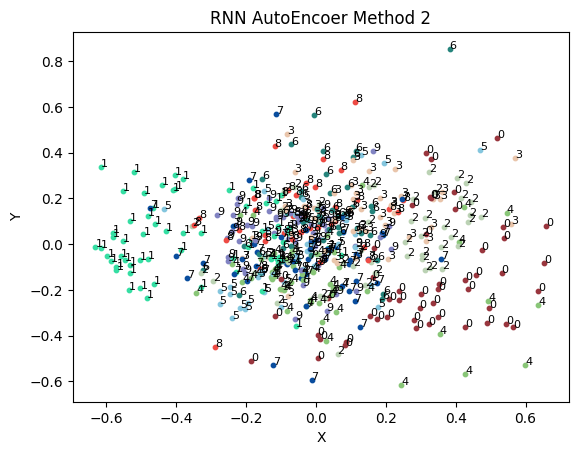

<Figure size 1400x1000 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt

for i in range(500):
    plt.text(pca_result[i][0], pca_result[i][1], train_set[i][1], fontsize=8)
    plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])

# نام‌گذاری محورها
plt.xlabel('X')
plt.ylabel('Y')

# عنوان نمودار
plt.title('RNN AutoEncoer Method 2')
plt.figure(figsize=(14, 10))
# نمایش نمودار
plt.show()

# 3- **CNN AutoEncoer**

## Train Functions 🧮

In [61]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())

      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [62]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss_valid.update(loss.item())
  return loss_valid.avg, inputs, outputs

## model

In [63]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # input size, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), # -> layer output size, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 14) # -> layer output size, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 14), # -> N, 32, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # layer output size, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## **Train**

In [64]:
model = Autoencoder()
model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [65]:
loss_train_hist = []
loss_valid_hist = []
outputs = []

best_loss_valid = torch.inf
epoch_counter = 0

In [66]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid, inputs, out_puts = validation(model,
                        test_loader,
                        loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  outputs.append((epoch, inputs, out_puts))

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 469/469 [00:18<00:00, 25.70batch/s, loss=0.0337]


Valid: Loss = 0.008116



Epoch 1: 100%|██████████| 469/469 [00:19<00:00, 23.76batch/s, loss=0.00622]


Valid: Loss = 0.004713



Epoch 2: 100%|██████████| 469/469 [00:16<00:00, 28.33batch/s, loss=0.00439]


Valid: Loss = 0.003843



Epoch 3: 100%|██████████| 469/469 [00:15<00:00, 31.17batch/s, loss=0.00388]


Valid: Loss = 0.003616



Epoch 4: 100%|██████████| 469/469 [00:14<00:00, 31.33batch/s, loss=0.0037]


Valid: Loss = 0.003474



Epoch 5: 100%|██████████| 469/469 [00:14<00:00, 31.34batch/s, loss=0.00358]


Valid: Loss = 0.003449



Epoch 6: 100%|██████████| 469/469 [00:14<00:00, 31.47batch/s, loss=0.00348]


Valid: Loss = 0.003398



Epoch 7: 100%|██████████| 469/469 [00:15<00:00, 31.08batch/s, loss=0.00341]


Valid: Loss = 0.00325



Epoch 8: 100%|██████████| 469/469 [00:15<00:00, 31.09batch/s, loss=0.00335]


Valid: Loss = 0.003245



Epoch 9: 100%|██████████| 469/469 [00:14<00:00, 31.60batch/s, loss=0.00328]


Valid: Loss = 0.003167



Epoch 10: 100%|██████████| 469/469 [00:15<00:00, 31.22batch/s, loss=0.00324]


Valid: Loss = 0.003137



Epoch 11: 100%|██████████| 469/469 [00:15<00:00, 30.70batch/s, loss=0.0032]


Valid: Loss = 0.003111



Epoch 12: 100%|██████████| 469/469 [00:15<00:00, 30.70batch/s, loss=0.00316]


Valid: Loss = 0.003103



Epoch 13: 100%|██████████| 469/469 [00:14<00:00, 31.56batch/s, loss=0.00312]


Valid: Loss = 0.003053



Epoch 14: 100%|██████████| 469/469 [00:15<00:00, 30.87batch/s, loss=0.0031]


Valid: Loss = 0.003043



Epoch 15: 100%|██████████| 469/469 [00:15<00:00, 31.00batch/s, loss=0.00308]


Valid: Loss = 0.003



Epoch 16: 100%|██████████| 469/469 [00:14<00:00, 31.51batch/s, loss=0.00308]


Valid: Loss = 0.003



Epoch 17: 100%|██████████| 469/469 [00:15<00:00, 30.83batch/s, loss=0.00305]


Valid: Loss = 0.002942



Epoch 18: 100%|██████████| 469/469 [00:15<00:00, 30.79batch/s, loss=0.00303]


Valid: Loss = 0.002984



Epoch 19: 100%|██████████| 469/469 [00:15<00:00, 30.95batch/s, loss=0.00303]


Valid: Loss = 0.002966



Epoch 20: 100%|██████████| 469/469 [00:14<00:00, 31.41batch/s, loss=0.00301]


Valid: Loss = 0.002947



Epoch 21: 100%|██████████| 469/469 [00:15<00:00, 31.17batch/s, loss=0.003]


Valid: Loss = 0.002968



Epoch 22: 100%|██████████| 469/469 [00:15<00:00, 30.96batch/s, loss=0.003]


Valid: Loss = 0.002913



Epoch 23: 100%|██████████| 469/469 [00:15<00:00, 31.14batch/s, loss=0.00299]


Valid: Loss = 0.002907



Epoch 24: 100%|██████████| 469/469 [00:15<00:00, 31.01batch/s, loss=0.00298]


Valid: Loss = 0.002907



Epoch 25: 100%|██████████| 469/469 [00:15<00:00, 30.33batch/s, loss=0.00297]


Valid: Loss = 0.00295



Epoch 26: 100%|██████████| 469/469 [00:15<00:00, 31.06batch/s, loss=0.00297]


Valid: Loss = 0.002907



Epoch 27: 100%|██████████| 469/469 [00:14<00:00, 31.38batch/s, loss=0.00297]


Valid: Loss = 0.002873



Epoch 28: 100%|██████████| 469/469 [00:14<00:00, 31.33batch/s, loss=0.00296]


Valid: Loss = 0.002932



Epoch 29: 100%|██████████| 469/469 [00:15<00:00, 30.86batch/s, loss=0.00295]


Valid: Loss = 0.002874



## save and load model

In [67]:
torch.save(model, '/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer.pth')
model = torch.load('/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer.pth')

## vitualize

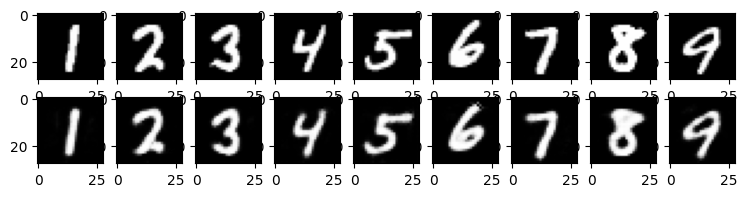

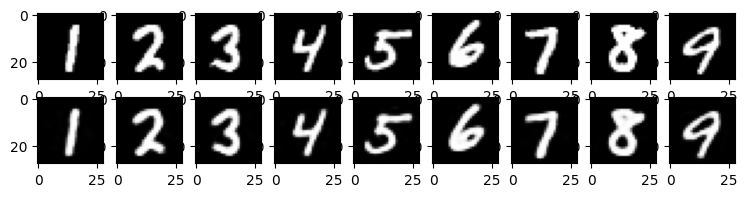

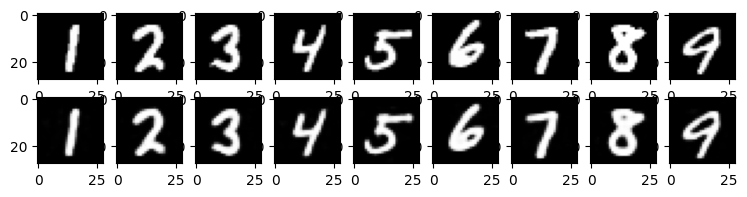

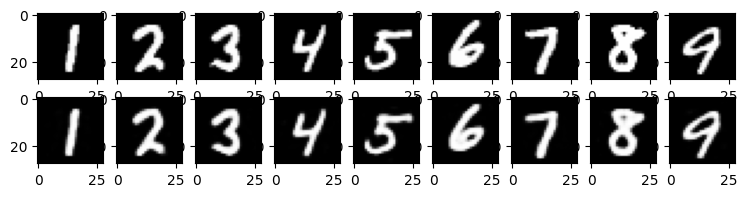

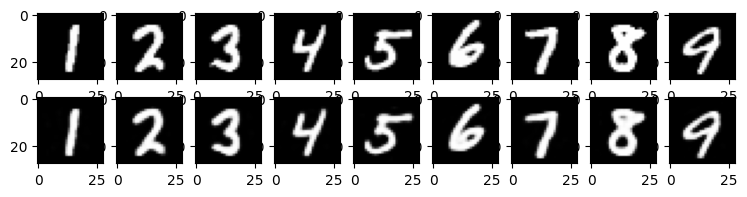

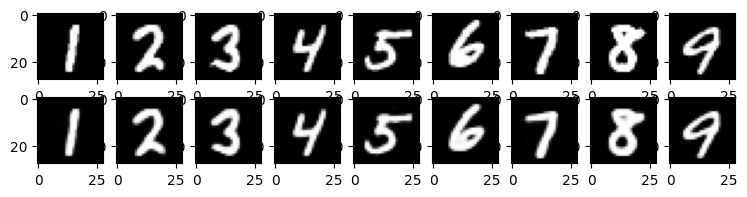

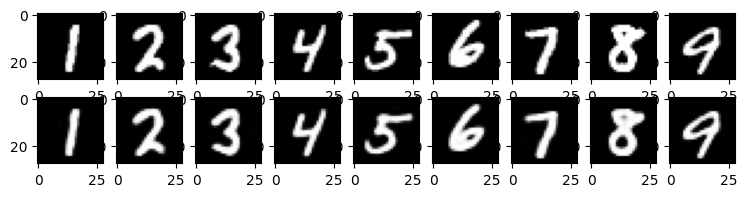

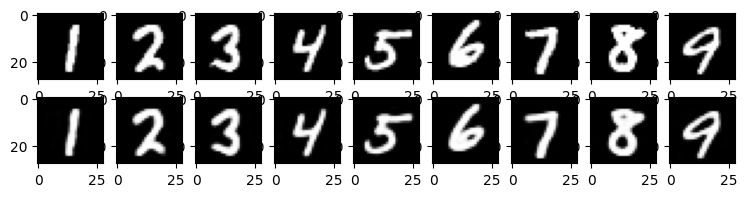

In [68]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [69]:
embded = []
encoder = model.encoder
for i in range(500):
  image = train_set[i][0].to(device)
  encoded_image = encoder(image)
  embded.append(encoded_image.squeeze().detach().cpu().numpy())
embded_array = np.array(embded)

In [70]:
embded_array.shape

(500, 64)

In [71]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embded_array)

<ipython-input-72-97b56172de5e>:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])


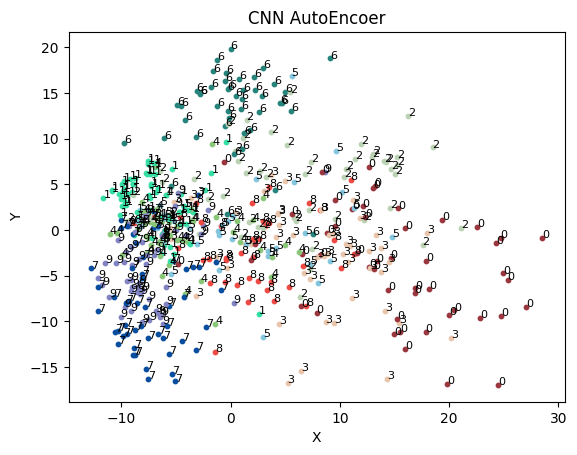

<Figure size 1400x1000 with 0 Axes>

In [72]:
import matplotlib.pyplot as plt

for i in range(500):
    plt.text(pca_result[i][0], pca_result[i][1], train_set[i][1], fontsize=8)
    plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])

# نام‌گذاری محورها
plt.xlabel('X')
plt.ylabel('Y')

# عنوان نمودار
plt.title('CNN AutoEncoer')
plt.figure(figsize=(14, 10))
# نمایش نمودار
plt.show()

# 4- **CNN AutoEncoer** layer number Test

## Train Functions 🧮

In [73]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())

      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [74]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss_valid.update(loss.item())
  return loss_valid.avg, inputs, outputs

## model

In [75]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # input size, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), # -> layer output size, 8, 14, 14
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1), # -> layer output size, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> layer output size, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), # -> layer output size, 32, 4, 4
            nn.ReLU(),
            nn.Conv2d(32, 64, 4) # -> layer output size, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # layer output size, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # layer output size, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## **Train**

In [76]:
model = Autoencoder()
model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [77]:
loss_train_hist = []
loss_valid_hist = []
outputs = []

best_loss_valid = torch.inf
epoch_counter = 0

In [78]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid, inputs, out_puts = validation(model,
                        test_loader,
                        loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  outputs.append((epoch, inputs, out_puts))

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 469/469 [00:12<00:00, 38.11batch/s, loss=0.0578]


Valid: Loss = 0.02391



Epoch 1: 100%|██████████| 469/469 [00:12<00:00, 39.00batch/s, loss=0.0173]


Valid: Loss = 0.01265



Epoch 2: 100%|██████████| 469/469 [00:11<00:00, 39.86batch/s, loss=0.0112]


Valid: Loss = 0.009438



Epoch 3: 100%|██████████| 469/469 [00:11<00:00, 40.32batch/s, loss=0.00881]


Valid: Loss = 0.007697



Epoch 4: 100%|██████████| 469/469 [00:11<00:00, 39.81batch/s, loss=0.00734]


Valid: Loss = 0.006613



Epoch 5: 100%|██████████| 469/469 [00:11<00:00, 39.91batch/s, loss=0.00642]


Valid: Loss = 0.005859



Epoch 6: 100%|██████████| 469/469 [00:11<00:00, 39.58batch/s, loss=0.00579]


Valid: Loss = 0.005334



Epoch 7: 100%|██████████| 469/469 [00:11<00:00, 39.63batch/s, loss=0.00532]


Valid: Loss = 0.004923



Epoch 8: 100%|██████████| 469/469 [00:12<00:00, 38.64batch/s, loss=0.00493]


Valid: Loss = 0.00459



Epoch 9: 100%|██████████| 469/469 [00:12<00:00, 38.61batch/s, loss=0.00462]


Valid: Loss = 0.004321



Epoch 10: 100%|██████████| 469/469 [00:12<00:00, 38.36batch/s, loss=0.00432]


Valid: Loss = 0.004091



Epoch 11: 100%|██████████| 469/469 [00:12<00:00, 37.88batch/s, loss=0.00408]


Valid: Loss = 0.003775



Epoch 12: 100%|██████████| 469/469 [00:12<00:00, 38.10batch/s, loss=0.00385]


Valid: Loss = 0.00366



Epoch 13: 100%|██████████| 469/469 [00:12<00:00, 37.81batch/s, loss=0.00366]


Valid: Loss = 0.003466



Epoch 14: 100%|██████████| 469/469 [00:12<00:00, 38.11batch/s, loss=0.0035]


Valid: Loss = 0.003276



Epoch 15: 100%|██████████| 469/469 [00:12<00:00, 38.26batch/s, loss=0.00335]


Valid: Loss = 0.003172



Epoch 16: 100%|██████████| 469/469 [00:12<00:00, 37.97batch/s, loss=0.00323]


Valid: Loss = 0.003077



Epoch 17: 100%|██████████| 469/469 [00:12<00:00, 37.35batch/s, loss=0.00312]


Valid: Loss = 0.003045



Epoch 18: 100%|██████████| 469/469 [00:12<00:00, 38.45batch/s, loss=0.00302]


Valid: Loss = 0.002899



Epoch 19: 100%|██████████| 469/469 [00:11<00:00, 39.44batch/s, loss=0.00294]


Valid: Loss = 0.002813



Epoch 20: 100%|██████████| 469/469 [00:11<00:00, 40.01batch/s, loss=0.00286]


Valid: Loss = 0.002821



Epoch 21: 100%|██████████| 469/469 [00:11<00:00, 39.47batch/s, loss=0.0028]


Valid: Loss = 0.002743



Epoch 22: 100%|██████████| 469/469 [00:11<00:00, 40.09batch/s, loss=0.00275]


Valid: Loss = 0.00266



Epoch 23: 100%|██████████| 469/469 [00:11<00:00, 40.42batch/s, loss=0.00271]


Valid: Loss = 0.002775



Epoch 24: 100%|██████████| 469/469 [00:11<00:00, 39.12batch/s, loss=0.00267]


Valid: Loss = 0.002549



Epoch 25: 100%|██████████| 469/469 [00:12<00:00, 38.74batch/s, loss=0.00263]


Valid: Loss = 0.002509



Epoch 26: 100%|██████████| 469/469 [00:12<00:00, 38.13batch/s, loss=0.00261]


Valid: Loss = 0.00259



Epoch 27: 100%|██████████| 469/469 [00:12<00:00, 37.93batch/s, loss=0.00259]


Valid: Loss = 0.002552



Epoch 28: 100%|██████████| 469/469 [00:12<00:00, 38.03batch/s, loss=0.00256]


Valid: Loss = 0.00253



Epoch 29: 100%|██████████| 469/469 [00:12<00:00, 37.14batch/s, loss=0.00254]


Valid: Loss = 0.002483



## save and load model

In [79]:
torch.save(model, '/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_layer_number_Test.pth')
model = torch.load('/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_layer_number_Test.pth')

## vitualize

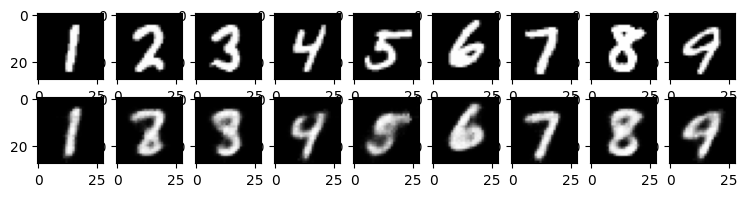

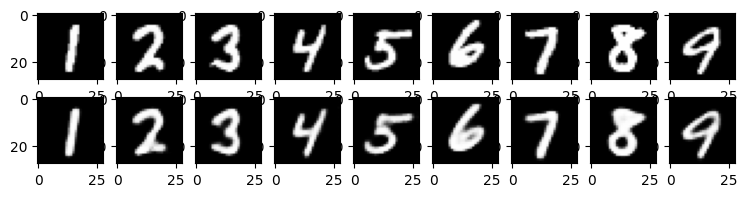

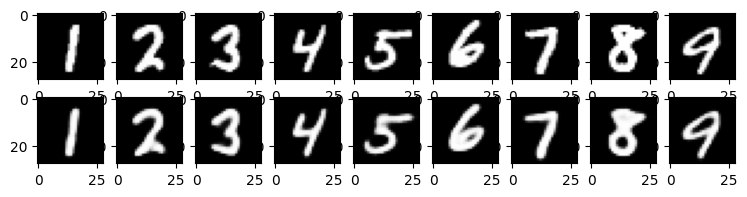

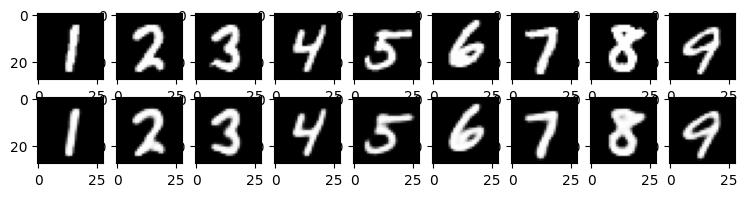

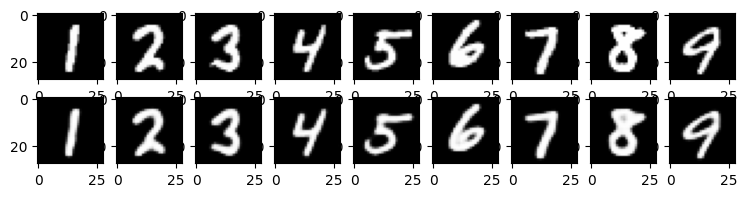

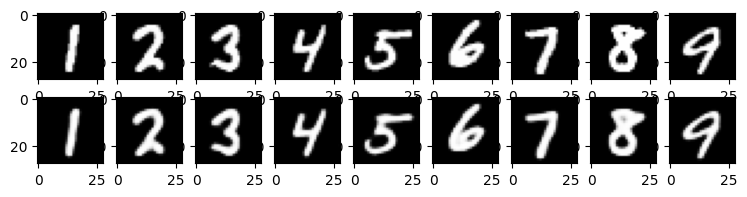

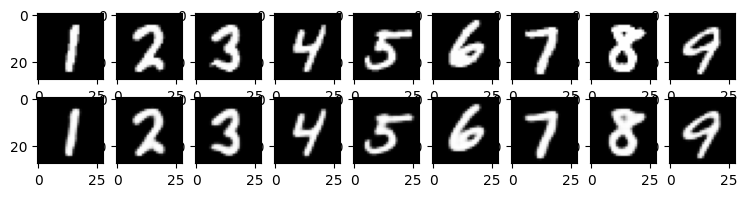

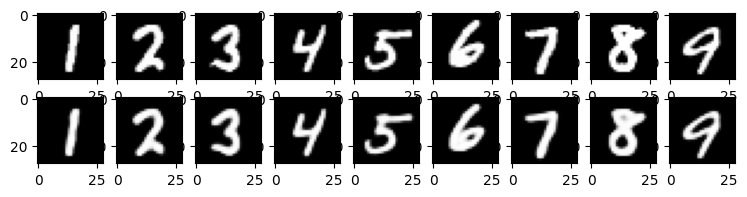

In [80]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [81]:
embded = []
encoder = model.encoder
for i in range(500):
  image = train_set[i][0].to(device)
  encoded_image = encoder(image)
  embded.append(encoded_image.squeeze().detach().cpu().numpy())
embded_array = np.array(embded)

In [82]:
embded_array.shape

(500, 64)

In [83]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embded_array)

<ipython-input-84-7033ddfffbdd>:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])


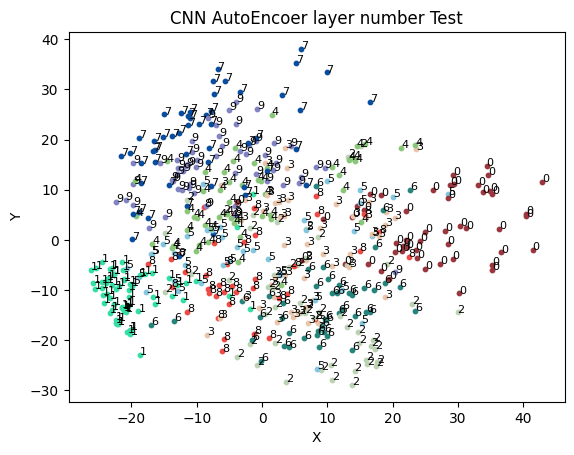

<Figure size 1400x1000 with 0 Axes>

In [84]:
import matplotlib.pyplot as plt

for i in range(500):
    plt.text(pca_result[i][0], pca_result[i][1], train_set[i][1], fontsize=8)
    plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])

# نام‌گذاری محورها
plt.xlabel('X')
plt.ylabel('Y')

# عنوان نمودار
plt.title('CNN AutoEncoer layer number Test')
plt.figure(figsize=(14, 10))
# نمایش نمودار
plt.show()

# 5- **CNN AutoEncoer** Neuron  number Test

## Train Functions 🧮

In [85]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())

      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [86]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss_valid.update(loss.item())
  return loss_valid.avg, inputs, outputs

## model

In [87]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # input size, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> layer output size, 8, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), # -> layer output size, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> layer output size, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # -> layer output size, 32, 4, 4
            nn.ReLU(),
            nn.Conv2d(64, 128, 4) # -> layer output size, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1), # layer output size, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # layer output size, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## **Train**

In [88]:
model = Autoencoder()
model = model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [89]:
loss_train_hist = []
loss_valid_hist = []
outputs = []

best_loss_valid = torch.inf
epoch_counter = 0

In [90]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid, inputs, out_puts = validation(model,
                        test_loader,
                        loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  outputs.append((epoch, inputs, out_puts))

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 469/469 [00:12<00:00, 36.19batch/s, loss=0.0451]


Valid: Loss = 0.01512



Epoch 1: 100%|██████████| 469/469 [00:12<00:00, 36.26batch/s, loss=0.0116]


Valid: Loss = 0.00904



Epoch 2: 100%|██████████| 469/469 [00:13<00:00, 35.48batch/s, loss=0.00806]


Valid: Loss = 0.006757



Epoch 3: 100%|██████████| 469/469 [00:13<00:00, 35.67batch/s, loss=0.00637]


Valid: Loss = 0.005704



Epoch 4: 100%|██████████| 469/469 [00:13<00:00, 35.23batch/s, loss=0.00553]


Valid: Loss = 0.005035



Epoch 5: 100%|██████████| 469/469 [00:13<00:00, 35.09batch/s, loss=0.00493]


Valid: Loss = 0.00453



Epoch 6: 100%|██████████| 469/469 [00:13<00:00, 35.57batch/s, loss=0.00449]


Valid: Loss = 0.004187



Epoch 7: 100%|██████████| 469/469 [00:13<00:00, 35.66batch/s, loss=0.00412]


Valid: Loss = 0.003755



Epoch 8: 100%|██████████| 469/469 [00:13<00:00, 35.62batch/s, loss=0.0038]


Valid: Loss = 0.003513



Epoch 9: 100%|██████████| 469/469 [00:13<00:00, 35.80batch/s, loss=0.00354]


Valid: Loss = 0.003389



Epoch 10: 100%|██████████| 469/469 [00:13<00:00, 35.28batch/s, loss=0.00334]


Valid: Loss = 0.003172



Epoch 11: 100%|██████████| 469/469 [00:13<00:00, 35.74batch/s, loss=0.00315]


Valid: Loss = 0.003053



Epoch 12: 100%|██████████| 469/469 [00:13<00:00, 35.80batch/s, loss=0.00301]


Valid: Loss = 0.002854



Epoch 13: 100%|██████████| 469/469 [00:13<00:00, 35.42batch/s, loss=0.00288]


Valid: Loss = 0.002852



Epoch 14: 100%|██████████| 469/469 [00:13<00:00, 34.56batch/s, loss=0.00277]


Valid: Loss = 0.002756



Epoch 15: 100%|██████████| 469/469 [00:13<00:00, 35.00batch/s, loss=0.00267]


Valid: Loss = 0.002545



Epoch 16: 100%|██████████| 469/469 [00:13<00:00, 35.45batch/s, loss=0.00257]


Valid: Loss = 0.002475



Epoch 17: 100%|██████████| 469/469 [00:13<00:00, 35.82batch/s, loss=0.0025]


Valid: Loss = 0.002412



Epoch 18: 100%|██████████| 469/469 [00:13<00:00, 35.70batch/s, loss=0.00243]


Valid: Loss = 0.002363



Epoch 19: 100%|██████████| 469/469 [00:13<00:00, 35.34batch/s, loss=0.00235]


Valid: Loss = 0.0023



Epoch 20: 100%|██████████| 469/469 [00:13<00:00, 35.81batch/s, loss=0.0023]


Valid: Loss = 0.002221



Epoch 21: 100%|██████████| 469/469 [00:13<00:00, 35.58batch/s, loss=0.00225]


Valid: Loss = 0.002182



Epoch 22: 100%|██████████| 469/469 [00:13<00:00, 35.86batch/s, loss=0.0022]


Valid: Loss = 0.002176



Epoch 23: 100%|██████████| 469/469 [00:13<00:00, 35.15batch/s, loss=0.00216]


Valid: Loss = 0.002078



Epoch 24: 100%|██████████| 469/469 [00:13<00:00, 35.79batch/s, loss=0.00211]


Valid: Loss = 0.002058



Epoch 25: 100%|██████████| 469/469 [00:13<00:00, 35.56batch/s, loss=0.00209]


Valid: Loss = 0.001988



Epoch 26: 100%|██████████| 469/469 [00:13<00:00, 35.66batch/s, loss=0.00205]


Valid: Loss = 0.001977



Epoch 27: 100%|██████████| 469/469 [00:13<00:00, 35.30batch/s, loss=0.00201]


Valid: Loss = 0.001936



Epoch 28: 100%|██████████| 469/469 [00:13<00:00, 35.16batch/s, loss=0.00199]


Valid: Loss = 0.00192



Epoch 29: 100%|██████████| 469/469 [00:13<00:00, 35.34batch/s, loss=0.00195]


Valid: Loss = 0.001892



## save and load model

In [91]:
torch.save(model, '/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_Neuron_number_Test.pth')
model = torch.load('/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_Neuron_number_Test.pth')

## vitualize

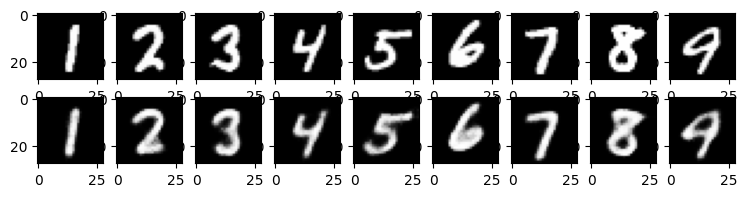

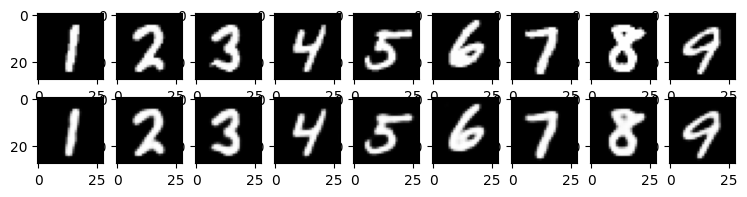

In [92]:
for k in range(0, num_epochs, 20):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [93]:
embded = []
encoder = model.encoder
for i in range(500):
  image = train_set[i][0].to(device)
  encoded_image = encoder(image)
  embded.append(encoded_image.squeeze().detach().cpu().numpy())
embded_array = np.array(embded)

In [94]:
embded_array.shape

(500, 128)

In [95]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embded_array)

<ipython-input-96-dad39d2e6c4f>:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])


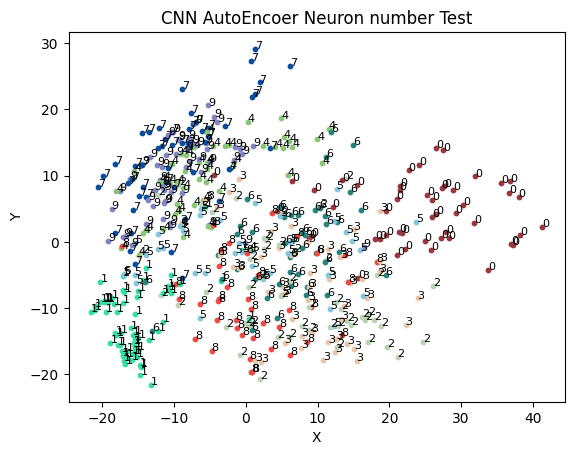

<Figure size 1400x1000 with 0 Axes>

In [96]:
import matplotlib.pyplot as plt

for i in range(500):
    plt.text(pca_result[i][0], pca_result[i][1], train_set[i][1], fontsize=8)
    plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])

# نام‌گذاری محورها
plt.xlabel('X')
plt.ylabel('Y')

# عنوان نمودار
plt.title('CNN AutoEncoer Neuron number Test')
plt.figure(figsize=(14, 10))
# نمایش نمودار
plt.show()

# 6- **CNN AutoEncoer** Loss function Test -L1 loss

## Train Functions 🧮

In [97]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())

      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [98]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss_valid.update(loss.item())
  return loss_valid.avg, inputs, outputs

## model

In [99]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # input size, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> layer output size, 8, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), # -> layer output size, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> layer output size, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # -> layer output size, 32, 4, 4
            nn.ReLU(),
            nn.Conv2d(64, 128, 4) # -> layer output size, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1), # layer output size, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # layer output size, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## **Train**

In [100]:
model = Autoencoder()
model = model.to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [101]:
loss_train_hist = []
loss_valid_hist = []
outputs = []

best_loss_valid = torch.inf
epoch_counter = 0

In [102]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid, inputs, out_puts = validation(model,
                        test_loader,
                        loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  outputs.append((epoch, inputs, out_puts))

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 469/469 [00:13<00:00, 35.49batch/s, loss=0.114]


Valid: Loss = 0.05897



Epoch 1: 100%|██████████| 469/469 [00:13<00:00, 35.58batch/s, loss=0.0436]


Valid: Loss = 0.03394



Epoch 2: 100%|██████████| 469/469 [00:13<00:00, 35.38batch/s, loss=0.0315]


Valid: Loss = 0.02783



Epoch 3: 100%|██████████| 469/469 [00:13<00:00, 35.29batch/s, loss=0.0268]


Valid: Loss = 0.02486



Epoch 4: 100%|██████████| 469/469 [00:13<00:00, 35.17batch/s, loss=0.0238]


Valid: Loss = 0.02233



Epoch 5: 100%|██████████| 469/469 [00:13<00:00, 35.33batch/s, loss=0.0218]


Valid: Loss = 0.02078



Epoch 6: 100%|██████████| 469/469 [00:13<00:00, 35.40batch/s, loss=0.0205]


Valid: Loss = 0.01943



Epoch 7: 100%|██████████| 469/469 [00:13<00:00, 35.19batch/s, loss=0.0195]


Valid: Loss = 0.01871



Epoch 8: 100%|██████████| 469/469 [00:13<00:00, 35.83batch/s, loss=0.0186]


Valid: Loss = 0.01815



Epoch 9: 100%|██████████| 469/469 [00:13<00:00, 35.19batch/s, loss=0.0179]


Valid: Loss = 0.01723



Epoch 10: 100%|██████████| 469/469 [00:13<00:00, 34.65batch/s, loss=0.0173]


Valid: Loss = 0.01661



Epoch 11: 100%|██████████| 469/469 [00:13<00:00, 35.73batch/s, loss=0.0168]


Valid: Loss = 0.0164



Epoch 12: 100%|██████████| 469/469 [00:13<00:00, 34.45batch/s, loss=0.0164]


Valid: Loss = 0.01588



Epoch 13: 100%|██████████| 469/469 [00:13<00:00, 34.89batch/s, loss=0.0159]


Valid: Loss = 0.01546



Epoch 14: 100%|██████████| 469/469 [00:13<00:00, 35.55batch/s, loss=0.0156]


Valid: Loss = 0.01516



Epoch 15: 100%|██████████| 469/469 [00:13<00:00, 35.11batch/s, loss=0.0153]


Valid: Loss = 0.01498



Epoch 16: 100%|██████████| 469/469 [00:13<00:00, 35.09batch/s, loss=0.015]


Valid: Loss = 0.01486



Epoch 17: 100%|██████████| 469/469 [00:13<00:00, 35.29batch/s, loss=0.0147]


Valid: Loss = 0.01453



Epoch 18: 100%|██████████| 469/469 [00:13<00:00, 35.09batch/s, loss=0.0145]


Valid: Loss = 0.01412



Epoch 19: 100%|██████████| 469/469 [00:13<00:00, 35.54batch/s, loss=0.0143]


Valid: Loss = 0.01387



Epoch 20: 100%|██████████| 469/469 [00:13<00:00, 35.20batch/s, loss=0.0141]


Valid: Loss = 0.01373



Epoch 21: 100%|██████████| 469/469 [00:13<00:00, 35.26batch/s, loss=0.0139]


Valid: Loss = 0.01352



Epoch 22: 100%|██████████| 469/469 [00:13<00:00, 35.21batch/s, loss=0.0137]


Valid: Loss = 0.01332



Epoch 23: 100%|██████████| 469/469 [00:13<00:00, 35.30batch/s, loss=0.0135]


Valid: Loss = 0.01333



Epoch 24: 100%|██████████| 469/469 [00:13<00:00, 35.39batch/s, loss=0.0133]


Valid: Loss = 0.01374



Epoch 25: 100%|██████████| 469/469 [00:13<00:00, 35.23batch/s, loss=0.0132]


Valid: Loss = 0.01306



Epoch 26: 100%|██████████| 469/469 [00:13<00:00, 35.85batch/s, loss=0.0131]


Valid: Loss = 0.01261



Epoch 27: 100%|██████████| 469/469 [00:13<00:00, 35.20batch/s, loss=0.0129]


Valid: Loss = 0.01281



Epoch 28: 100%|██████████| 469/469 [00:13<00:00, 35.56batch/s, loss=0.0128]


Valid: Loss = 0.01273



Epoch 29: 100%|██████████| 469/469 [00:13<00:00, 35.55batch/s, loss=0.0127]


Valid: Loss = 0.01241



## save and load model

In [103]:
torch.save(model, '/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_Loss_function_Test_L1_loss.pth')
model = torch.load('/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_Loss_function_Test_L1_loss.pth')

## vitualize

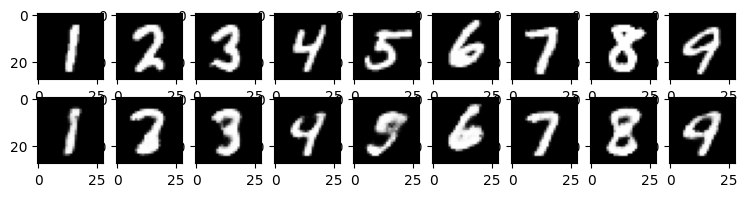

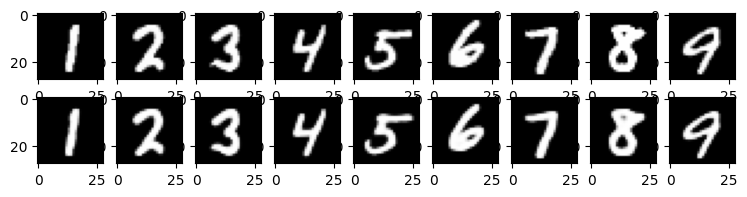

In [104]:
for k in range(0, num_epochs, 20):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [105]:
embded = []
encoder = model.encoder
for i in range(500):
  image = train_set[i][0].to(device)
  encoded_image = encoder(image)
  embded.append(encoded_image.squeeze().detach().cpu().numpy())
embded_array = np.array(embded)

In [106]:
embded_array.shape

(500, 128)

In [107]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embded_array)

<ipython-input-108-36b2e21686e5>:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])


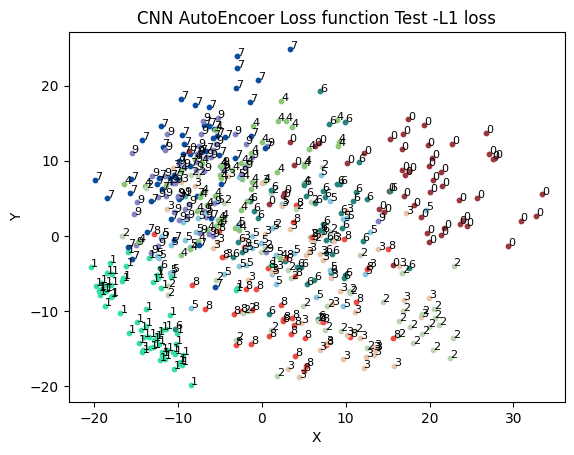

<Figure size 1400x1000 with 0 Axes>

In [108]:
import matplotlib.pyplot as plt

for i in range(500):
    plt.text(pca_result[i][0], pca_result[i][1], train_set[i][1], fontsize=8)
    plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])

# نام‌گذاری محورها
plt.xlabel('X')
plt.ylabel('Y')

# عنوان نمودار
plt.title('CNN AutoEncoer Loss function Test -L1 loss')
plt.figure(figsize=(14, 10))
# نمایش نمودار
plt.show()

# 7- **CNN AutoEncoer** Loss function Test -Huber loss

## Train Functions 🧮

In [109]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())

      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [110]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss_valid.update(loss.item())
  return loss_valid.avg, inputs, outputs

## model

In [111]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # input size, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> layer output size, 8, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), # -> layer output size, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> layer output size, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # -> layer output size, 32, 4, 4
            nn.ReLU(),
            nn.Conv2d(64, 128, 4) # -> layer output size, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1), # layer output size, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # layer output size, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## **Train**

In [112]:
model = Autoencoder()
model = model.to(device)

loss_fn = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [113]:
loss_train_hist = []
loss_valid_hist = []
outputs = []

best_loss_valid = torch.inf
epoch_counter = 0

In [114]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid, inputs, out_puts = validation(model,
                        test_loader,
                        loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  outputs.append((epoch, inputs, out_puts))

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 469/469 [00:13<00:00, 35.46batch/s, loss=0.0219]


Valid: Loss = 0.007164



Epoch 1: 100%|██████████| 469/469 [00:12<00:00, 36.31batch/s, loss=0.00558]


Valid: Loss = 0.004225



Epoch 2: 100%|██████████| 469/469 [00:13<00:00, 36.01batch/s, loss=0.00375]


Valid: Loss = 0.00317



Epoch 3: 100%|██████████| 469/469 [00:12<00:00, 36.13batch/s, loss=0.00299]


Valid: Loss = 0.002705



Epoch 4: 100%|██████████| 469/469 [00:12<00:00, 36.15batch/s, loss=0.00261]


Valid: Loss = 0.002416



Epoch 5: 100%|██████████| 469/469 [00:13<00:00, 35.98batch/s, loss=0.00236]


Valid: Loss = 0.002186



Epoch 6: 100%|██████████| 469/469 [00:12<00:00, 36.61batch/s, loss=0.00216]


Valid: Loss = 0.002059



Epoch 7: 100%|██████████| 469/469 [00:13<00:00, 35.91batch/s, loss=0.00199]


Valid: Loss = 0.001828



Epoch 8: 100%|██████████| 469/469 [00:13<00:00, 35.78batch/s, loss=0.00184]


Valid: Loss = 0.001716



Epoch 9: 100%|██████████| 469/469 [00:13<00:00, 35.36batch/s, loss=0.00174]


Valid: Loss = 0.001632



Epoch 10: 100%|██████████| 469/469 [00:13<00:00, 35.54batch/s, loss=0.00165]


Valid: Loss = 0.001577



Epoch 11: 100%|██████████| 469/469 [00:13<00:00, 35.47batch/s, loss=0.00158]


Valid: Loss = 0.001498



Epoch 12: 100%|██████████| 469/469 [00:13<00:00, 35.40batch/s, loss=0.00151]


Valid: Loss = 0.001439



Epoch 13: 100%|██████████| 469/469 [00:13<00:00, 34.46batch/s, loss=0.00147]


Valid: Loss = 0.001429



Epoch 14: 100%|██████████| 469/469 [00:13<00:00, 35.37batch/s, loss=0.00142]


Valid: Loss = 0.001315



Epoch 15: 100%|██████████| 469/469 [00:13<00:00, 35.34batch/s, loss=0.00138]


Valid: Loss = 0.001321



Epoch 16: 100%|██████████| 469/469 [00:13<00:00, 35.25batch/s, loss=0.00134]


Valid: Loss = 0.001277



Epoch 17: 100%|██████████| 469/469 [00:14<00:00, 32.88batch/s, loss=0.00131]


Valid: Loss = 0.001258



Epoch 18: 100%|██████████| 469/469 [00:13<00:00, 35.62batch/s, loss=0.00128]


Valid: Loss = 0.001202



Epoch 19: 100%|██████████| 469/469 [00:13<00:00, 35.59batch/s, loss=0.00125]


Valid: Loss = 0.001204



Epoch 20: 100%|██████████| 469/469 [00:13<00:00, 35.63batch/s, loss=0.00123]


Valid: Loss = 0.001177



Epoch 21: 100%|██████████| 469/469 [00:13<00:00, 35.28batch/s, loss=0.00121]


Valid: Loss = 0.001206



Epoch 22: 100%|██████████| 469/469 [00:13<00:00, 35.24batch/s, loss=0.00118]


Valid: Loss = 0.001163



Epoch 23: 100%|██████████| 469/469 [00:13<00:00, 35.34batch/s, loss=0.00117]


Valid: Loss = 0.001124



Epoch 24: 100%|██████████| 469/469 [00:13<00:00, 35.26batch/s, loss=0.00115]


Valid: Loss = 0.001104



Epoch 25: 100%|██████████| 469/469 [00:13<00:00, 35.03batch/s, loss=0.00113]


Valid: Loss = 0.001115



Epoch 26: 100%|██████████| 469/469 [00:13<00:00, 34.92batch/s, loss=0.00112]


Valid: Loss = 0.00111



Epoch 27: 100%|██████████| 469/469 [00:13<00:00, 35.18batch/s, loss=0.0011]


Valid: Loss = 0.001078



Epoch 28: 100%|██████████| 469/469 [00:13<00:00, 35.35batch/s, loss=0.00109]


Valid: Loss = 0.001018



Epoch 29: 100%|██████████| 469/469 [00:13<00:00, 35.42batch/s, loss=0.00107]


Valid: Loss = 0.00105



## save and load model

In [115]:
torch.save(model, '/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_Loss_function_Test_L1_loss.pth')
model = torch.load('/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_Loss_function_Test_L1_loss.pth')

## vitualize

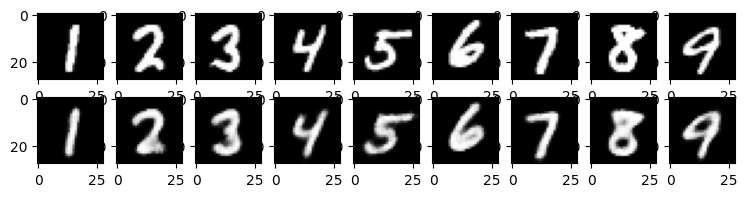

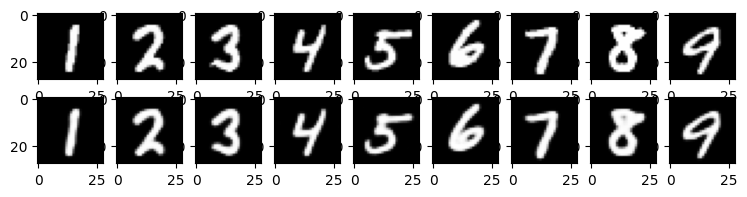

In [116]:
for k in range(0, num_epochs, 20):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [117]:
embded = []
encoder = model.encoder
for i in range(500):
  image = train_set[i][0].to(device)
  encoded_image = encoder(image)
  embded.append(encoded_image.squeeze().detach().cpu().numpy())
embded_array = np.array(embded)

In [118]:
embded_array.shape

(500, 128)

In [119]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embded_array)

<ipython-input-120-5a0ff64ec49f>:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])


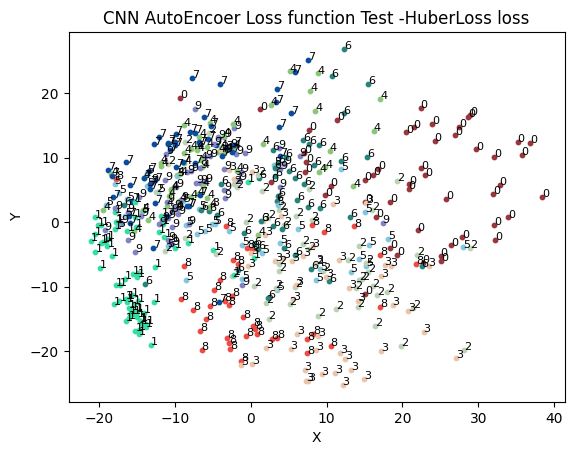

<Figure size 1400x1000 with 0 Axes>

In [120]:
import matplotlib.pyplot as plt

for i in range(500):
    plt.text(pca_result[i][0], pca_result[i][1], train_set[i][1], fontsize=8)
    plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])

# نام‌گذاری محورها
plt.xlabel('X')
plt.ylabel('Y')

# عنوان نمودار
plt.title('CNN AutoEncoer Loss function Test -HuberLoss loss')
plt.figure(figsize=(14, 10))
# نمایش نمودار
plt.show()

# 8- **CNN AutoEncoer** Optimizer Test - SGD with momentum

## Train Functions 🧮

In [64]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())

      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [65]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss_valid.update(loss.item())
  return loss_valid.avg, inputs, outputs

## model

In [66]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # input size, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> layer output size, 8, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), # -> layer output size, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> layer output size, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # -> layer output size, 32, 4, 4
            nn.ReLU(),
            nn.Conv2d(64, 128, 4) # -> layer output size, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1), # layer output size, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # layer output size, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## **Train**

In [67]:
model = Autoencoder()
model = model.to(device)

loss_fn = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.SGD(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5,
                             momentum=0.7)

In [68]:
loss_train_hist = []
loss_valid_hist = []
outputs = []

best_loss_valid = torch.inf
epoch_counter = 0

In [69]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid, inputs, out_puts = validation(model,
                        test_loader,
                        loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  outputs.append((epoch, inputs, out_puts))

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 469/469 [00:13<00:00, 34.58batch/s, loss=0.108]


Valid: Loss = 0.1018



Epoch 1: 100%|██████████| 469/469 [00:13<00:00, 35.08batch/s, loss=0.0965]


Valid: Loss = 0.09189



Epoch 2: 100%|██████████| 469/469 [00:13<00:00, 33.78batch/s, loss=0.0876]


Valid: Loss = 0.08402



Epoch 3: 100%|██████████| 469/469 [00:13<00:00, 35.62batch/s, loss=0.0805]


Valid: Loss = 0.07781



Epoch 4: 100%|██████████| 469/469 [00:13<00:00, 35.15batch/s, loss=0.0749]


Valid: Loss = 0.07288



Epoch 5: 100%|██████████| 469/469 [00:14<00:00, 32.32batch/s, loss=0.0704]


Valid: Loss = 0.06895



Epoch 6: 100%|██████████| 469/469 [00:14<00:00, 33.16batch/s, loss=0.0669]


Valid: Loss = 0.06578



Epoch 7: 100%|██████████| 469/469 [00:13<00:00, 35.00batch/s, loss=0.064]


Valid: Loss = 0.06322



Epoch 8: 100%|██████████| 469/469 [00:13<00:00, 34.91batch/s, loss=0.0616]


Valid: Loss = 0.06112



Epoch 9: 100%|██████████| 469/469 [00:13<00:00, 34.93batch/s, loss=0.0597]


Valid: Loss = 0.05939



Epoch 10: 100%|██████████| 469/469 [00:13<00:00, 35.09batch/s, loss=0.0581]


Valid: Loss = 0.05795



Epoch 11: 100%|██████████| 469/469 [00:13<00:00, 35.18batch/s, loss=0.0568]


Valid: Loss = 0.05674



Epoch 12: 100%|██████████| 469/469 [00:13<00:00, 34.71batch/s, loss=0.0556]


Valid: Loss = 0.05573



Epoch 13: 100%|██████████| 469/469 [00:13<00:00, 34.04batch/s, loss=0.0547]


Valid: Loss = 0.05487



Epoch 14: 100%|██████████| 469/469 [00:13<00:00, 34.91batch/s, loss=0.0539]


Valid: Loss = 0.05414



Epoch 15: 100%|██████████| 469/469 [00:13<00:00, 34.87batch/s, loss=0.0532]


Valid: Loss = 0.05351



Epoch 16: 100%|██████████| 469/469 [00:13<00:00, 35.57batch/s, loss=0.0526]


Valid: Loss = 0.05296



Epoch 17: 100%|██████████| 469/469 [00:13<00:00, 35.46batch/s, loss=0.0521]


Valid: Loss = 0.05249



Epoch 18: 100%|██████████| 469/469 [00:13<00:00, 35.46batch/s, loss=0.0516]


Valid: Loss = 0.05208



Epoch 19: 100%|██████████| 469/469 [00:13<00:00, 35.19batch/s, loss=0.0512]


Valid: Loss = 0.05172



Epoch 20: 100%|██████████| 469/469 [00:13<00:00, 35.43batch/s, loss=0.0509]


Valid: Loss = 0.0514



Epoch 21: 100%|██████████| 469/469 [00:13<00:00, 35.31batch/s, loss=0.0506]


Valid: Loss = 0.05113



Epoch 22: 100%|██████████| 469/469 [00:12<00:00, 36.10batch/s, loss=0.0503]


Valid: Loss = 0.05088



Epoch 23: 100%|██████████| 469/469 [00:13<00:00, 35.08batch/s, loss=0.0501]


Valid: Loss = 0.05066



Epoch 24: 100%|██████████| 469/469 [00:13<00:00, 35.01batch/s, loss=0.0498]


Valid: Loss = 0.05047



Epoch 25: 100%|██████████| 469/469 [00:13<00:00, 35.07batch/s, loss=0.0496]


Valid: Loss = 0.05029



Epoch 26: 100%|██████████| 469/469 [00:13<00:00, 35.55batch/s, loss=0.0495]


Valid: Loss = 0.05014



Epoch 27: 100%|██████████| 469/469 [00:14<00:00, 32.66batch/s, loss=0.0493]


Valid: Loss = 0.05



Epoch 28: 100%|██████████| 469/469 [00:14<00:00, 32.85batch/s, loss=0.0492]


Valid: Loss = 0.04987



Epoch 29: 100%|██████████| 469/469 [00:14<00:00, 33.47batch/s, loss=0.0491]


Valid: Loss = 0.04976



## save and load model

In [70]:
torch.save(model, '/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_optimizer_Test_SGD.pth')
model = torch.load('/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_optimizer_Test_SGD.pth')

## vitualize

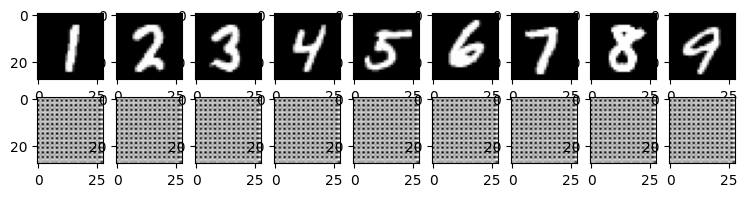

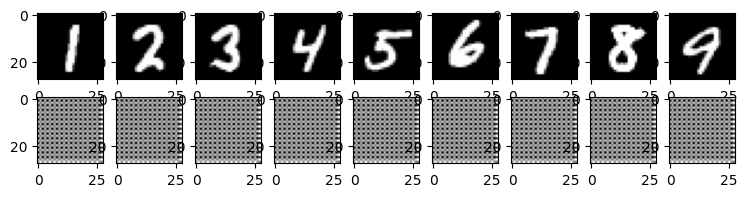

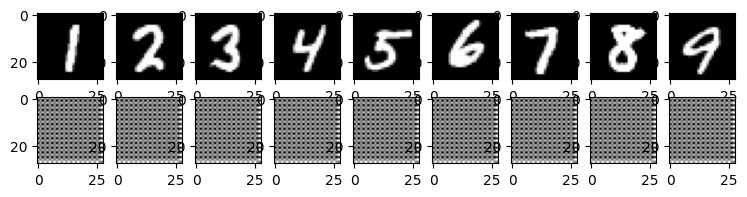

In [77]:
for k in range(0, num_epochs, 10):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [78]:
embded = []
encoder = model.encoder
for i in range(500):
  image = train_set[i][0].to(device)
  encoded_image = encoder(image)
  embded.append(encoded_image.squeeze().detach().cpu().numpy())
embded_array = np.array(embded)

In [79]:
embded_array.shape

(500, 128)

In [80]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embded_array)

<ipython-input-81-15232cb595d3>:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])


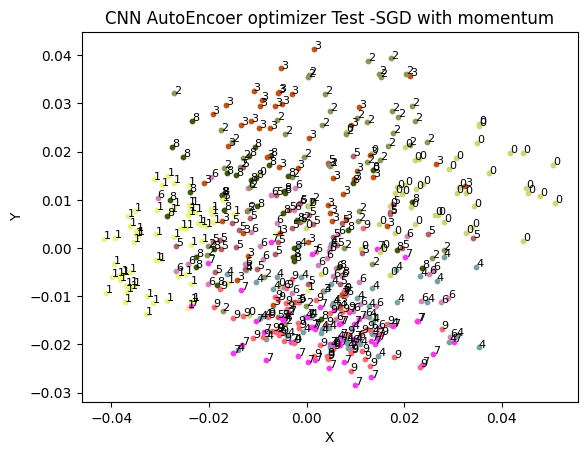

<Figure size 1400x1000 with 0 Axes>

In [81]:
import matplotlib.pyplot as plt

for i in range(500):
    plt.text(pca_result[i][0], pca_result[i][1], train_set[i][1], fontsize=8)
    plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])

# نام‌گذاری محورها
plt.xlabel('X')
plt.ylabel('Y')

# عنوان نمودار
plt.title('CNN AutoEncoer optimizer Test -SGD with momentum')
plt.figure(figsize=(14, 10))
# نمایش نمودار
plt.show()

# **Dataset - batch size=8🗂️**

## Transform

In [22]:
transform_train = transforms.Compose([
    transforms.ToTensor()
    ])

transform_test = transforms.Compose([
    transforms.ToTensor()
    ])

## MNIST Dataset

In [23]:
train_set = datasets.MNIST('./', train=True, transform = transform_train, download=True)

test_set = datasets.MNIST('./', train=False, transform = transform_test, download=True)

In [24]:
# جهت تست مدل
# _, mini_train_set = random_split(train_set, (len(train_set)-500, 500))
# _, mini_test_set = random_split(test_set, (len(test_set)-100, 100))

In [25]:
train_set.data.shape

torch.Size([60000, 28, 28])

In [26]:
train_set.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [27]:
torch.FloatTensor(train_set.data/255.).mean(dim=[0, 1,2])
torch.FloatTensor(train_set.data/255.).std(dim=[0, 1,2])

tensor(0.3081)

## DataLoader

In [28]:
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

## Visualize

In [29]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

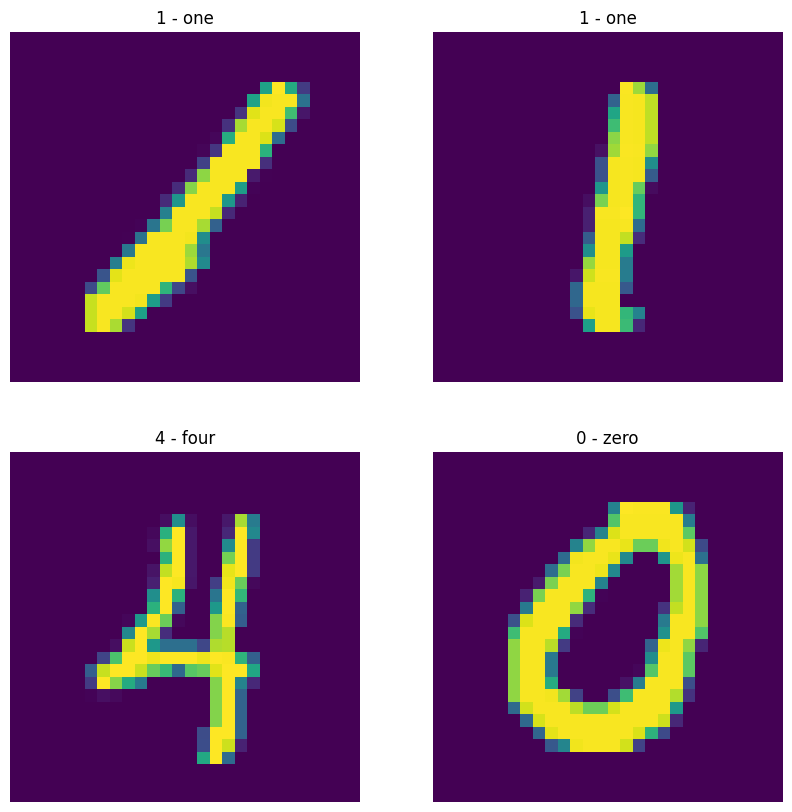

In [30]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# 9- **CNN AutoEncoer** Batch size=8

## Train Functions 🧮

In [31]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())

      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [32]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss_valid.update(loss.item())
  return loss_valid.avg, inputs, outputs

## model

In [33]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # input size, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> layer output size, 8, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), # -> layer output size, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # -> layer output size, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), # -> layer output size, 32, 4, 4
            nn.ReLU(),
            nn.Conv2d(64, 128, 4) # -> layer output size, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1), # layer output size, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # layer output size, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## **Train**

In [34]:
model = Autoencoder()
model = model.to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [35]:
loss_train_hist = []
loss_valid_hist = []
outputs = []

best_loss_valid = torch.inf
epoch_counter = 0

In [36]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid, inputs, out_puts = validation(model,
                        test_loader,
                        loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  outputs.append((epoch, inputs, out_puts))

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 7500/7500 [01:16<00:00, 97.65batch/s, loss=0.0528] 


Valid: Loss = 0.02459



Epoch 1: 100%|██████████| 7500/7500 [01:18<00:00, 95.05batch/s, loss=0.0218]


Valid: Loss = 0.01958



Epoch 2: 100%|██████████| 7500/7500 [01:17<00:00, 96.51batch/s, loss=0.0187] 


Valid: Loss = 0.01766



Epoch 3: 100%|██████████| 7500/7500 [01:19<00:00, 94.36batch/s, loss=0.0171]


Valid: Loss = 0.01648



Epoch 4: 100%|██████████| 7500/7500 [01:15<00:00, 98.85batch/s, loss=0.016]


Valid: Loss = 0.01551



Epoch 5: 100%|██████████| 7500/7500 [01:15<00:00, 99.50batch/s, loss=0.0153] 


Valid: Loss = 0.01449



Epoch 6: 100%|██████████| 7500/7500 [01:17<00:00, 96.99batch/s, loss=0.0148] 


Valid: Loss = 0.01437



Epoch 7: 100%|██████████| 7500/7500 [01:15<00:00, 98.89batch/s, loss=0.0143] 


Valid: Loss = 0.01379



Epoch 8: 100%|██████████| 7500/7500 [01:17<00:00, 97.19batch/s, loss=0.014]


Valid: Loss = 0.01352



Epoch 9: 100%|██████████| 7500/7500 [01:16<00:00, 98.16batch/s, loss=0.0137] 


Valid: Loss = 0.01327



Epoch 10: 100%|██████████| 7500/7500 [01:17<00:00, 97.19batch/s, loss=0.0134]


Valid: Loss = 0.01309



Epoch 11: 100%|██████████| 7500/7500 [01:16<00:00, 98.61batch/s, loss=0.0132] 


Valid: Loss = 0.01301



Epoch 12: 100%|██████████| 7500/7500 [01:16<00:00, 98.06batch/s, loss=0.013]


Valid: Loss = 0.01309



Epoch 13: 100%|██████████| 7500/7500 [01:17<00:00, 97.33batch/s, loss=0.0129] 


Valid: Loss = 0.01248



Epoch 14: 100%|██████████| 7500/7500 [01:16<00:00, 98.49batch/s, loss=0.0127] 


Valid: Loss = 0.01247



Epoch 15: 100%|██████████| 7500/7500 [01:16<00:00, 97.60batch/s, loss=0.0126]


Valid: Loss = 0.01238



Epoch 16: 100%|██████████| 7500/7500 [01:17<00:00, 96.91batch/s, loss=0.0125]


Valid: Loss = 0.01226



Epoch 17: 100%|██████████| 7500/7500 [01:16<00:00, 98.16batch/s, loss=0.0124]


Valid: Loss = 0.01217



Epoch 18: 100%|██████████| 7500/7500 [01:17<00:00, 97.10batch/s, loss=0.0123] 


Valid: Loss = 0.01207



Epoch 19: 100%|██████████| 7500/7500 [01:16<00:00, 97.90batch/s, loss=0.0122]


Valid: Loss = 0.01196



Epoch 20: 100%|██████████| 7500/7500 [01:16<00:00, 97.60batch/s, loss=0.0122]


Valid: Loss = 0.01223



Epoch 21: 100%|██████████| 7500/7500 [01:17<00:00, 97.19batch/s, loss=0.0121] 


Valid: Loss = 0.01176



Epoch 22: 100%|██████████| 7500/7500 [01:19<00:00, 94.78batch/s, loss=0.0121]


Valid: Loss = 0.01178



Epoch 23: 100%|██████████| 7500/7500 [01:16<00:00, 97.79batch/s, loss=0.012] 


Valid: Loss = 0.01189



Epoch 24: 100%|██████████| 7500/7500 [01:17<00:00, 96.75batch/s, loss=0.012] 


Valid: Loss = 0.01197



Epoch 25: 100%|██████████| 7500/7500 [01:19<00:00, 93.94batch/s, loss=0.012]


Valid: Loss = 0.01189



Epoch 26: 100%|██████████| 7500/7500 [01:17<00:00, 97.39batch/s, loss=0.0119]


Valid: Loss = 0.0116



Epoch 27: 100%|██████████| 7500/7500 [01:17<00:00, 96.70batch/s, loss=0.0119]


Valid: Loss = 0.01183



Epoch 28: 100%|██████████| 7500/7500 [01:17<00:00, 96.95batch/s, loss=0.0119]


Valid: Loss = 0.01183



Epoch 29: 100%|██████████| 7500/7500 [01:18<00:00, 95.77batch/s, loss=0.0118]


Valid: Loss = 0.01161



## save and load model

In [37]:
torch.save(model, '/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_batchsize8.pth')
model = torch.load('/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_batchsize8.pth')

## vitualize

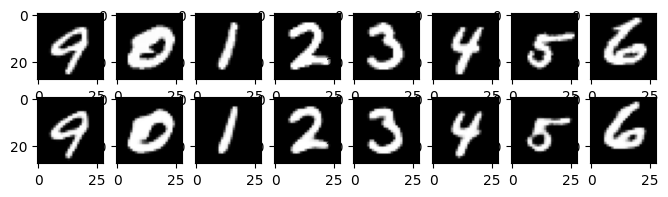

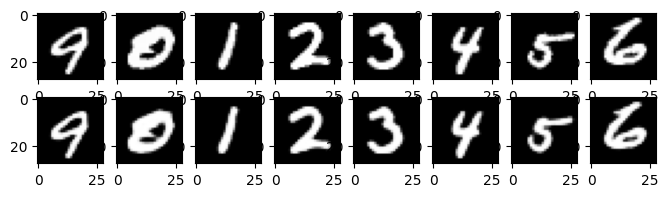

In [38]:
for k in range(0, num_epochs, 20):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [39]:
embded = []
encoder = model.encoder
for i in range(500):
  image = train_set[i][0].to(device)
  encoded_image = encoder(image)
  embded.append(encoded_image.squeeze().detach().cpu().numpy())
embded_array = np.array(embded)

In [40]:
embded_array.shape

(500, 128)

In [41]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embded_array)

<ipython-input-42-a65d27810528>:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])


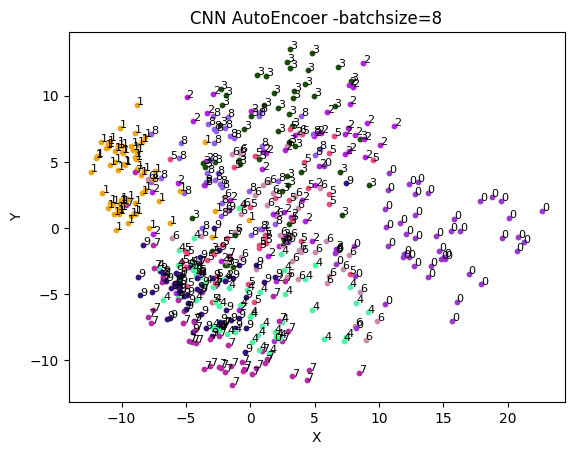

<Figure size 1400x1000 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt

for i in range(500):
    plt.text(pca_result[i][0], pca_result[i][1], train_set[i][1], fontsize=8)
    plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])

# نام‌گذاری محورها
plt.xlabel('X')
plt.ylabel('Y')

# عنوان نمودار
plt.title('CNN AutoEncoer -batchsize=8')
plt.figure(figsize=(14, 10))
# نمایش نمودار
plt.show()

# 10- **CNN AutoEncoer** Last Model -L1 loss - Adam optizer -Batch size=128

## Train Functions 🧮

In [68]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())

      tepoch.set_postfix(loss=loss_train.avg)
  return model, loss_train.avg

In [69]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      # targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, inputs)

      loss_valid.update(loss.item())
  return loss_valid.avg, inputs, outputs

## model

In [70]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # input size, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), # -> layer output size, 8, 14, 14
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1), # -> layer output size, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> layer output size, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), # -> layer output size, 32, 4, 4
            nn.ReLU(),
            nn.Conv2d(32, 64, 4) # -> layer output size, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # layer output size, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # layer output size, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## **Train**

In [71]:
model = Autoencoder()
model = model.to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [72]:
loss_train_hist = []
loss_valid_hist = []
outputs = []

best_loss_valid = torch.inf
epoch_counter = 0

In [73]:
num_epochs = 100

for epoch in range(num_epochs):
  # Train
  model, loss_train = train_one_epoch(model,
                                      train_loader,
                                      loss_fn,
                                      optimizer,
                                      epoch)
  # Validation
  loss_valid, inputs, out_puts = validation(model,
                        test_loader,
                        loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  outputs.append((epoch, inputs, out_puts))

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 469/469 [00:14<00:00, 33.43batch/s, loss=0.142]


Valid: Loss = 0.1035



Epoch 1: 100%|██████████| 469/469 [00:12<00:00, 37.04batch/s, loss=0.0682]


Valid: Loss = 0.04803



Epoch 2: 100%|██████████| 469/469 [00:13<00:00, 35.00batch/s, loss=0.0418]


Valid: Loss = 0.03626



Epoch 3: 100%|██████████| 469/469 [00:12<00:00, 37.35batch/s, loss=0.0344]


Valid: Loss = 0.03136



Epoch 4: 100%|██████████| 469/469 [00:12<00:00, 39.02batch/s, loss=0.0302]


Valid: Loss = 0.02788



Epoch 5: 100%|██████████| 469/469 [00:12<00:00, 36.33batch/s, loss=0.0275]


Valid: Loss = 0.02583



Epoch 6: 100%|██████████| 469/469 [00:12<00:00, 37.20batch/s, loss=0.0256]


Valid: Loss = 0.02453



Epoch 7: 100%|██████████| 469/469 [00:12<00:00, 37.29batch/s, loss=0.0243]


Valid: Loss = 0.0232



Epoch 8: 100%|██████████| 469/469 [00:12<00:00, 36.26batch/s, loss=0.0232]


Valid: Loss = 0.02228



Epoch 9: 100%|██████████| 469/469 [00:11<00:00, 39.24batch/s, loss=0.0223]


Valid: Loss = 0.02135



Epoch 10: 100%|██████████| 469/469 [00:12<00:00, 37.90batch/s, loss=0.0215]


Valid: Loss = 0.02102



Epoch 11: 100%|██████████| 469/469 [00:12<00:00, 38.76batch/s, loss=0.0208]


Valid: Loss = 0.02032



Epoch 12: 100%|██████████| 469/469 [00:12<00:00, 36.93batch/s, loss=0.0201]


Valid: Loss = 0.01943



Epoch 13: 100%|██████████| 469/469 [00:12<00:00, 38.67batch/s, loss=0.0196]


Valid: Loss = 0.01882



Epoch 14: 100%|██████████| 469/469 [00:12<00:00, 36.30batch/s, loss=0.019]


Valid: Loss = 0.01838



Epoch 15: 100%|██████████| 469/469 [00:12<00:00, 38.66batch/s, loss=0.0185]


Valid: Loss = 0.0179



Epoch 16: 100%|██████████| 469/469 [00:12<00:00, 36.99batch/s, loss=0.018]


Valid: Loss = 0.01751



Epoch 17: 100%|██████████| 469/469 [00:12<00:00, 36.97batch/s, loss=0.0176]


Valid: Loss = 0.01726



Epoch 18: 100%|██████████| 469/469 [00:12<00:00, 37.81batch/s, loss=0.0173]


Valid: Loss = 0.01677



Epoch 19: 100%|██████████| 469/469 [00:13<00:00, 33.99batch/s, loss=0.017]


Valid: Loss = 0.01653



Epoch 20: 100%|██████████| 469/469 [00:12<00:00, 36.11batch/s, loss=0.0167]


Valid: Loss = 0.01635



Epoch 21: 100%|██████████| 469/469 [00:14<00:00, 32.95batch/s, loss=0.0164]


Valid: Loss = 0.01597



Epoch 22: 100%|██████████| 469/469 [00:13<00:00, 34.18batch/s, loss=0.0162]


Valid: Loss = 0.01581



Epoch 23: 100%|██████████| 469/469 [00:12<00:00, 36.36batch/s, loss=0.016]


Valid: Loss = 0.01562



Epoch 24: 100%|██████████| 469/469 [00:12<00:00, 37.00batch/s, loss=0.0158]


Valid: Loss = 0.01542



Epoch 25: 100%|██████████| 469/469 [00:12<00:00, 38.02batch/s, loss=0.0157]


Valid: Loss = 0.01546



Epoch 26: 100%|██████████| 469/469 [00:12<00:00, 36.89batch/s, loss=0.0155]


Valid: Loss = 0.01536



Epoch 27: 100%|██████████| 469/469 [00:12<00:00, 37.89batch/s, loss=0.0154]


Valid: Loss = 0.01514



Epoch 28: 100%|██████████| 469/469 [00:12<00:00, 37.79batch/s, loss=0.0153]


Valid: Loss = 0.01496



Epoch 29: 100%|██████████| 469/469 [00:12<00:00, 37.56batch/s, loss=0.0152]


Valid: Loss = 0.01503



Epoch 30: 100%|██████████| 469/469 [00:12<00:00, 37.31batch/s, loss=0.0151]


Valid: Loss = 0.01485



Epoch 31: 100%|██████████| 469/469 [00:12<00:00, 37.17batch/s, loss=0.015]


Valid: Loss = 0.01491



Epoch 32: 100%|██████████| 469/469 [00:12<00:00, 37.59batch/s, loss=0.0149]


Valid: Loss = 0.01461



Epoch 33: 100%|██████████| 469/469 [00:12<00:00, 37.53batch/s, loss=0.0149]


Valid: Loss = 0.01476



Epoch 34: 100%|██████████| 469/469 [00:12<00:00, 37.51batch/s, loss=0.0148]


Valid: Loss = 0.01467



Epoch 35: 100%|██████████| 469/469 [00:12<00:00, 37.62batch/s, loss=0.0148]


Valid: Loss = 0.01491



Epoch 36: 100%|██████████| 469/469 [00:12<00:00, 37.76batch/s, loss=0.0147]


Valid: Loss = 0.01446



Epoch 37: 100%|██████████| 469/469 [00:12<00:00, 37.56batch/s, loss=0.0147]


Valid: Loss = 0.01449



Epoch 38: 100%|██████████| 469/469 [00:12<00:00, 37.93batch/s, loss=0.0146]


Valid: Loss = 0.0145



Epoch 39: 100%|██████████| 469/469 [00:12<00:00, 38.85batch/s, loss=0.0146]


Valid: Loss = 0.01439



Epoch 40: 100%|██████████| 469/469 [00:12<00:00, 38.85batch/s, loss=0.0145]


Valid: Loss = 0.01442



Epoch 41: 100%|██████████| 469/469 [00:12<00:00, 38.18batch/s, loss=0.0145]


Valid: Loss = 0.01429



Epoch 42: 100%|██████████| 469/469 [00:12<00:00, 36.64batch/s, loss=0.0145]


Valid: Loss = 0.01429



Epoch 43: 100%|██████████| 469/469 [00:12<00:00, 38.61batch/s, loss=0.0144]


Valid: Loss = 0.01433



Epoch 44: 100%|██████████| 469/469 [00:12<00:00, 38.92batch/s, loss=0.0144]


Valid: Loss = 0.01414



Epoch 45: 100%|██████████| 469/469 [00:12<00:00, 38.48batch/s, loss=0.0144]


Valid: Loss = 0.01411



Epoch 46: 100%|██████████| 469/469 [00:12<00:00, 37.86batch/s, loss=0.0143]


Valid: Loss = 0.01405



Epoch 47: 100%|██████████| 469/469 [00:12<00:00, 37.61batch/s, loss=0.0143]


Valid: Loss = 0.01413



Epoch 48: 100%|██████████| 469/469 [00:12<00:00, 37.30batch/s, loss=0.0143]


Valid: Loss = 0.01408



Epoch 49: 100%|██████████| 469/469 [00:12<00:00, 37.32batch/s, loss=0.0143]


Valid: Loss = 0.01399



Epoch 50: 100%|██████████| 469/469 [00:12<00:00, 37.79batch/s, loss=0.0143]


Valid: Loss = 0.01399



Epoch 51: 100%|██████████| 469/469 [00:12<00:00, 37.47batch/s, loss=0.0142]


Valid: Loss = 0.01403



Epoch 52: 100%|██████████| 469/469 [00:12<00:00, 37.25batch/s, loss=0.0142]


Valid: Loss = 0.01407



Epoch 53: 100%|██████████| 469/469 [00:12<00:00, 37.52batch/s, loss=0.0142]


Valid: Loss = 0.01394



Epoch 54: 100%|██████████| 469/469 [00:12<00:00, 36.88batch/s, loss=0.0141]


Valid: Loss = 0.01394



Epoch 55: 100%|██████████| 469/469 [00:12<00:00, 37.34batch/s, loss=0.0141]


Valid: Loss = 0.01389



Epoch 56: 100%|██████████| 469/469 [00:12<00:00, 37.11batch/s, loss=0.0141]


Valid: Loss = 0.01405



Epoch 57: 100%|██████████| 469/469 [00:12<00:00, 37.24batch/s, loss=0.0141]


Valid: Loss = 0.01391



Epoch 58: 100%|██████████| 469/469 [00:12<00:00, 37.87batch/s, loss=0.0141]


Valid: Loss = 0.01382



Epoch 59: 100%|██████████| 469/469 [00:12<00:00, 38.05batch/s, loss=0.0141]


Valid: Loss = 0.0138



Epoch 60: 100%|██████████| 469/469 [00:12<00:00, 38.15batch/s, loss=0.014]


Valid: Loss = 0.01383



Epoch 61: 100%|██████████| 469/469 [00:12<00:00, 37.65batch/s, loss=0.014]


Valid: Loss = 0.01391



Epoch 62: 100%|██████████| 469/469 [00:12<00:00, 37.51batch/s, loss=0.014]


Valid: Loss = 0.01384



Epoch 63: 100%|██████████| 469/469 [00:12<00:00, 38.00batch/s, loss=0.014]


Valid: Loss = 0.01373



Epoch 64: 100%|██████████| 469/469 [00:12<00:00, 37.41batch/s, loss=0.014]


Valid: Loss = 0.01368



Epoch 65: 100%|██████████| 469/469 [00:12<00:00, 37.41batch/s, loss=0.0139]


Valid: Loss = 0.01376



Epoch 66: 100%|██████████| 469/469 [00:12<00:00, 37.00batch/s, loss=0.0139]


Valid: Loss = 0.01394



Epoch 67: 100%|██████████| 469/469 [00:12<00:00, 37.11batch/s, loss=0.0139]


Valid: Loss = 0.01372



Epoch 68: 100%|██████████| 469/469 [00:12<00:00, 37.42batch/s, loss=0.0139]


Valid: Loss = 0.01368



Epoch 69: 100%|██████████| 469/469 [00:12<00:00, 37.43batch/s, loss=0.0139]


Valid: Loss = 0.01379



Epoch 70: 100%|██████████| 469/469 [00:12<00:00, 37.14batch/s, loss=0.0139]


Valid: Loss = 0.01372



Epoch 71: 100%|██████████| 469/469 [00:12<00:00, 36.78batch/s, loss=0.0138]


Valid: Loss = 0.01353



Epoch 72: 100%|██████████| 469/469 [00:12<00:00, 37.47batch/s, loss=0.0138]


Valid: Loss = 0.01358



Epoch 73: 100%|██████████| 469/469 [00:12<00:00, 37.04batch/s, loss=0.0138]


Valid: Loss = 0.01389



Epoch 74: 100%|██████████| 469/469 [00:12<00:00, 36.72batch/s, loss=0.0138]


Valid: Loss = 0.01361



Epoch 75: 100%|██████████| 469/469 [00:12<00:00, 36.37batch/s, loss=0.0138]


Valid: Loss = 0.01362



Epoch 76: 100%|██████████| 469/469 [00:12<00:00, 38.50batch/s, loss=0.0138]


Valid: Loss = 0.01373



Epoch 77: 100%|██████████| 469/469 [00:12<00:00, 38.44batch/s, loss=0.0138]


Valid: Loss = 0.0135



Epoch 78: 100%|██████████| 469/469 [00:12<00:00, 37.63batch/s, loss=0.0137]


Valid: Loss = 0.01364



Epoch 79: 100%|██████████| 469/469 [00:12<00:00, 37.55batch/s, loss=0.0137]


Valid: Loss = 0.01361



Epoch 80: 100%|██████████| 469/469 [00:12<00:00, 38.69batch/s, loss=0.0137]


Valid: Loss = 0.01345



Epoch 81: 100%|██████████| 469/469 [00:12<00:00, 36.45batch/s, loss=0.0137]


Valid: Loss = 0.01362



Epoch 82: 100%|██████████| 469/469 [00:12<00:00, 36.64batch/s, loss=0.0137]


Valid: Loss = 0.01374



Epoch 83: 100%|██████████| 469/469 [00:12<00:00, 36.88batch/s, loss=0.0137]


Valid: Loss = 0.01363



Epoch 84: 100%|██████████| 469/469 [00:12<00:00, 36.87batch/s, loss=0.0137]


Valid: Loss = 0.01364



Epoch 85: 100%|██████████| 469/469 [00:12<00:00, 37.13batch/s, loss=0.0137]


Valid: Loss = 0.01345



Epoch 86: 100%|██████████| 469/469 [00:12<00:00, 36.79batch/s, loss=0.0136]


Valid: Loss = 0.01349



Epoch 87: 100%|██████████| 469/469 [00:12<00:00, 36.97batch/s, loss=0.0136]


Valid: Loss = 0.01342



Epoch 88: 100%|██████████| 469/469 [00:12<00:00, 36.72batch/s, loss=0.0136]


Valid: Loss = 0.01341



Epoch 89: 100%|██████████| 469/469 [00:12<00:00, 37.09batch/s, loss=0.0136]


Valid: Loss = 0.01353



Epoch 90: 100%|██████████| 469/469 [00:12<00:00, 36.50batch/s, loss=0.0136]


Valid: Loss = 0.01349



Epoch 91: 100%|██████████| 469/469 [00:12<00:00, 36.58batch/s, loss=0.0136]


Valid: Loss = 0.01342



Epoch 92: 100%|██████████| 469/469 [00:12<00:00, 37.02batch/s, loss=0.0136]


Valid: Loss = 0.0134



Epoch 93: 100%|██████████| 469/469 [00:12<00:00, 36.59batch/s, loss=0.0136]


Valid: Loss = 0.01338



Epoch 94: 100%|██████████| 469/469 [00:12<00:00, 36.87batch/s, loss=0.0136]


Valid: Loss = 0.01357



Epoch 95: 100%|██████████| 469/469 [00:12<00:00, 36.64batch/s, loss=0.0136]


Valid: Loss = 0.01332



Epoch 96: 100%|██████████| 469/469 [00:12<00:00, 37.87batch/s, loss=0.0136]


Valid: Loss = 0.01346



Epoch 97: 100%|██████████| 469/469 [00:12<00:00, 36.85batch/s, loss=0.0135]


Valid: Loss = 0.01325



Epoch 98: 100%|██████████| 469/469 [00:12<00:00, 37.91batch/s, loss=0.0135]


Valid: Loss = 0.01338



Epoch 99: 100%|██████████| 469/469 [00:12<00:00, 38.93batch/s, loss=0.0135]


Valid: Loss = 0.01324



## save and load model

In [74]:
torch.save(model, '/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_Last_model.pth')
model = torch.load('/content/drive/MyDrive/Advance_deep/week2/CNN_AutoEncoer_Last_model.pth')

## vitualize

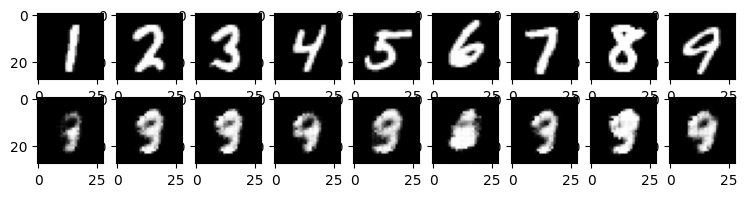

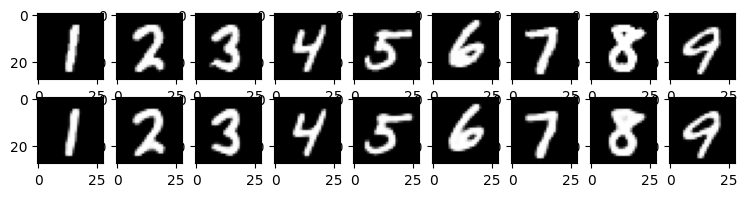

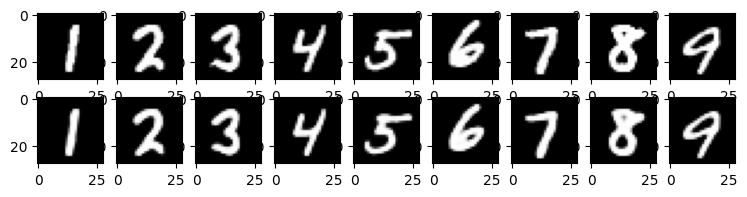

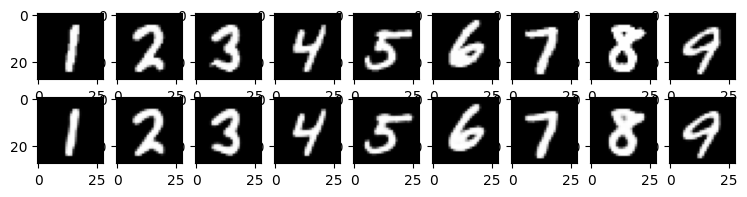

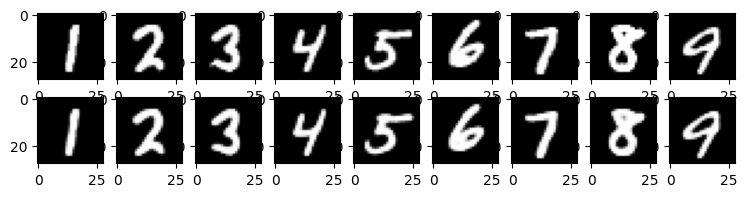

In [75]:
for k in range(0, num_epochs, 20):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

In [76]:
embded = []
encoder = model.encoder
for i in range(500):
  image = train_set[i][0].to(device)
  encoded_image = encoder(image)
  embded.append(encoded_image.squeeze().detach().cpu().numpy())
embded_array = np.array(embded)

In [77]:
embded_array.shape

(500, 64)

In [78]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embded_array)

<ipython-input-79-67b23df7e070>:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])


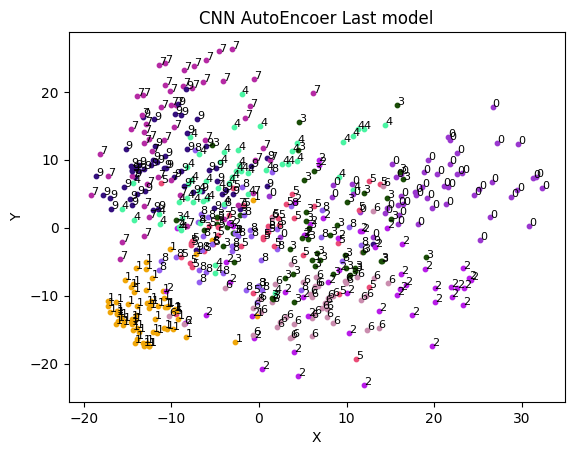

<Figure size 1400x1000 with 0 Axes>

In [79]:
import matplotlib.pyplot as plt

for i in range(500):
    plt.text(pca_result[i][0], pca_result[i][1], train_set[i][1], fontsize=8)
    plt.scatter(pca_result[i][0], pca_result[i][1], s=10,c=label_colors[train_set[i][1]])

# نام‌گذاری محورها
plt.xlabel('X')
plt.ylabel('Y')

# عنوان نمودار
plt.title('CNN AutoEncoer Last model')
plt.figure(figsize=(14, 10))
# نمایش نمودار
plt.show()

## 3D PCA and Plot (as Bounos)

In [ ]:
from sklearn.decomposition import PCA
n_components = 3
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(embded_array)

<ipython-input-85-700f2e1eb98e>:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pca_result[i][0], pca_result[i][1], pca_result[i][2], s=5,c=label_colors[train_set[i][1]])


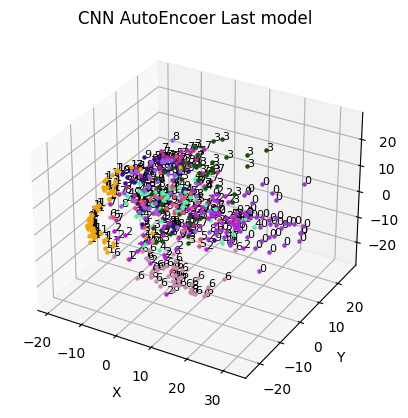

<Figure size 1400x1000 with 0 Axes>

In [85]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(500):
    ax.text(pca_result[i][0], pca_result[i][1], pca_result[i][2], train_set[i][1], fontsize=8)
    ax.scatter(pca_result[i][0], pca_result[i][1], pca_result[i][2], s=5,c=label_colors[train_set[i][1]])

# نام‌گذاری محورها

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# عنوان نمودار
plt.title('CNN AutoEncoer Last model')
plt.figure(figsize=(14, 10))
# نمایش نمودار
plt.show()